In [1]:
import subprocess
import sys

In [2]:
#noexport
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from fastai.basics import *


Bad key "text.kerning_factor" on line 4 in
/home/auri/anaconda3/envs/fastaiAP/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
if not IN_NOTEBOOK:
    class IPython():
        @staticmethod
        def system(cmd): print(subprocess.run(cmd.split(" "),text=True,capture_output=True).stdout)
    def get_ipython(): return IPython()
def install(package): subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [5]:
#noexport
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, IntSlider


In [6]:
import os

import torch
from fastai.vision.all import *
from fastai.distributed import *
import fastai
DistributedTrainer.fup=True #added
import sklearn.metrics as skm
import pandas as pd
#pd.set_option('display.max_rows', 50)
#pd.set_option('display.max_columns', 170)
#pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import pyplot as plt
import openslide
from numpy import asarray
import cv2

pd.set_option('display.max_columns', None)

from TMA_tools import Spot, TMA, WSI

#added
from collections import defaultdict
from sklearn.model_selection import GroupKFold
from torchvision import transforms
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import timm
from torchvision.models import *
from fastcore.script import *
import ast
import gc
from ast import literal_eval
import datatable as dt
import dcor
import seaborn as sns

In [7]:
#noexport
import fastai
fastai.__file__,fastai.__version__,torch.__version__

('/home/auri/anaconda3/envs/fastaiAP/lib/python3.7/site-packages/fastai/__init__.py',
 '2.1.5',
 '1.7.0')

In [8]:

#%run TMA_tools.ipynb

In [9]:
@call_parse
def main(
    lr:             Param("Learning rate", float)=5e-4,
    bs:             Param("Batchs size",int)=32,
    test_slices:    Param("Number of partitions of each record during test",int)=100,
    test_bs:        Param("Batchs size in test",int)=100,
    epochs:         Param("Epochs", int)=50,
    fold:           Param("Fold", int)=0, #if -1 then it is an inmutable single fold (no k-Folds) 
    folds:          Param("Number of fold", int)=5,
    j:              Param("Num workers", int)=8,
    arch:           Param("Conv trunk architecture",str) = 'efficientnet_b3',
    fp16:           Param("fp16 method: to_fp16, to_non_native_fp16, none", str) = 'noop',
    mixover:        Param("Use mixover",action='store_true')=False,
    mixup:          Param("Use mixup",action='store_true')=False,
    coord:          Param("Use coordconv",action='store_true')=True,
    do:             Param("Spectral dropout", float)=0.5,
    jitter:         Param("Jitter, percentage of total length, e.g. 0.1", float)=0.,
    wn:             Param("White noise in dB, e.g. 4", float)=0.,

    fit:            Param("fit, fit_one_cycle, fit_flat_cos", str) = 'fit_one_cycle',
    fit_kwargs:     Param("Optional args for fit,eg pct_start=0.1", str, nargs='+') = {},

    opt:            Param("Optimizer", str) = 'Adam',
    opt_kwargs:     Param("Optional args for opt, eg. eps=1e-4", str, nargs='+') = {},
    
    sample_rate:    Param("",int)=48000,
    window_size:    Param("",int)=1024*2,
    hop_size:       Param("",int)=480,
    res_time:       Param("",int)=224*2,
    res_freq:       Param("",int)=256,
    
    ext:            Param("",str)="/home/auri/EPICOLON",
    
    #model:          Param("",str)="",
    task:           Param("",str,choices=['train','precache','ensemble'])="train",
    preds:          Param("Pred filenames",str,nargs='+')=[],
    pred_weights:   Param("Pred filenames",float,nargs='+')=None,
    
    pseudolabel_fns: Param("Pseudolabels files",str,nargs='+')=['pseudo.csv'],
    pseudolabels:    Param("Use pseudolabels",action='store_true')=False,

    local_rank:     Param("--local_rank",int)=None,
    nproc_per_node: Param("--nproc_per_node",int)=None,
    #added
    dataset:   Param('Dataset used for training', str) = 'epicolon', # 'epicolon' ,'TCGA'
    weight:    Param('Class weighting', str) = 'label', # 'bias_label' 
    tissues:   Param('Type of tissues used for training', str, nargs='+')=['TUM','LYM','MUC'], #['TUM']['TUM','LYM','MUC']['TUM','STR', 'LYM', 'MUC']
    zoom_filter:  Param('Zoom level used for training', str)= None, # 0-4 in EPICOLON and 0-1 in TCGA. If None then all levels available
    pred_patient_img:  Param('Predict patient image with sliding tiles', action = 'store_true' ) = False,
    verbose:     Param("--verbose",bool)=False,
    test_saved_model:  Param('Name of the saved model for testing', str) = None, #if None then it will train a new model otherwise will test the saved model 
    control_bias:  Param('Control bias when training', int, nargs='+')=[1,2,3], #if empty then vanilla training, 1=control hospital bias, 2=control patient bias, 3=control TMA bias
    distillation_start:  Param('% of iterations in first epoch prior to bias distillation', int) = 50, #if 0 then distillation starts at the beginning  
    distillation_period:  Param('Number of iterations each bias distillation occurs', int) = 1 #if 1 then distillation is done on each iteration 
    
): 
    if opt_kwargs: opt_kwargs = {s.split('=')[0]:float(s.split('=')[1]) for s in opt_kwargs}
    if fit_kwargs: fit_kwargs = {s.split('=')[0]:float(s.split('=')[1]) for s in fit_kwargs}
    print(locals())
    globals().update({ 'a' : AttrDict(locals())})

In [10]:
#noexport
main(fp16='to_fp16', verbose = True,  #tissues = ['TUM'],
     #test_saved_model = "0_MSI_classifier_TissueBackbone_Corr_Loss_toy_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=[1]_start=0.0_period=1_maxepochs=10_AUC=0.9762973880852814",
     weight = 'bias_label', control_bias = [1], distillation_start = 0, distillation_period= 1  )

{'lr': 0.0005, 'bs': 32, 'test_slices': 100, 'test_bs': 100, 'epochs': 50, 'fold': 0, 'folds': 5, 'j': 8, 'arch': 'efficientnet_b3', 'fp16': 'to_fp16', 'mixover': False, 'mixup': False, 'coord': True, 'do': 0.5, 'jitter': 0.0, 'wn': 0.0, 'fit': 'fit_one_cycle', 'fit_kwargs': {}, 'opt': 'Adam', 'opt_kwargs': {}, 'sample_rate': 48000, 'window_size': 2048, 'hop_size': 480, 'res_time': 448, 'res_freq': 256, 'ext': '/home/auri/EPICOLON', 'task': 'train', 'preds': [], 'pred_weights': None, 'pseudolabel_fns': ['pseudo.csv'], 'pseudolabels': False, 'local_rank': None, 'nproc_per_node': None, 'dataset': 'epicolon', 'weight': 'bias_label', 'tissues': ['TUM', 'LYM', 'MUC'], 'zoom_filter': None, 'pred_patient_img': False, 'verbose': True, 'test_saved_model': None, 'control_bias': [1], 'distillation_start': 0, 'distillation_period': 1}


In [11]:
n_gpus = torch.cuda.device_count() if a.local_rank is None else 1
if a.local_rank is not None:
    torch.cuda.set_device(a.local_rank)
    torch.distributed.init_process_group(backend='nccl', init_method='env://')
    if a.j: a.j = min(1,a.j//num_distrib())
    print("DISTRIBUTED")

In [12]:

_p_csv = Path('dataset_level_all_March21_no_overlap_labeled_tissue.csv') #HGUA samples
p_csv = Path('dataset_level_all_no_overlap_labeled_tissue.csv') #Epicolon I and II
_p_csv_1 = Path('dataset_TCGA_MSI-H_level_0_no_overlap_labeled_tissue.csv') #TCGA MSI
_p_csv_0 = Path('dataset_TCGA_MSS_level_0_no_overlap_labeled_tissue.csv') #TCGA MSS


if a.dataset == 'TCGA':
    d = dt.fread(_p_csv_0).to_pandas()
    print(d.shape)
    _d = dt.fread(_p_csv_1).to_pandas()
    d = pd.concat([d,_d])
    d.shape #n tiles extracted from TCGA 

if a.dataset == 'epicolon':
    d = dt.fread(p_csv).to_pandas()
    print(d.shape)
    _d = dt.fread(_p_csv).to_pandas()
    d = pd.concat([d,_d])
    d.shape #n tiles extracted from EPICOLON I and II + HGUA  
    #correct labels in two patients with mixed labels in source data (verified with AP)
    d.loc[d.patient_ID == '13013', 'label'] = 2 #MSS
    d.loc[d.patient_ID == '06B0014684A','label'] = 1 #MSI



(957077, 12)


In [13]:
d = d.sample(frac = 0.0088, random_state = 123)



In [14]:

print(f'N patients IDs (if EPICOLON total is not disambiguated): {d.patient_ID.nunique()}, ( MSI {d.loc[d.label == 1].patient_ID.nunique()})')

N patients IDs (if EPICOLON total is not disambiguated): 2014, ( MSI 175)


In [15]:
def eval_fields(df):
    df.tile = df.tile.apply(lambda x: eval(str(x)))
    
    if a.dataset == 'epicolon':
        df.tile_rot_augmentation = df.tile_rot_augmentation.apply(lambda x: eval(str(x)))
    return df
df_split = np.array_split(d, 32)

res = parallel(partial(eval_fields), df_split)
d = pd.concat([*res])



In [16]:
#noexport
d['zoom'] = d.tile.apply(lambda o: o[3])
d.zoom.value_counts()

0    7059
1    1717
2     416
3     154
4      30
Name: zoom, dtype: int64

In [17]:

d.patient_ID = d.patient_ID.astype(str)



In [18]:
#disambiguate IDs
if a.dataset == 'epicolon':
    #print(d[d.patient_ID.str.contains('.0', regex = False)].patient_ID.nunique())
    d['patient_ID'] = d.patient_ID.str.replace('.0','', regex=False)
    #correct labels in two patients with mixed labels in source data (verified with AP)
    d.loc[d.patient_ID == '13013', 'label'] = 2 #MSS 
    d.loc[d.patient_ID == '06B0014684A','label'] = 1 #MSI
    print('after disambiguation')
    print(d.patient_ID.nunique(), d.loc[d.label == 1].patient_ID.nunique())
#df with a tile covering the entire area of each spot
ds_spot_4 = d.loc[d.zoom == 4] 


after disambiguation
1812 174


In [19]:
#experiment removing 21 (target 0 in HGUA )
print(d.shape)
d['HGUA'] = d.patient_ID.apply(lambda x: 1 if ('B' in x or '-' in x or x.startswith('12')) else 0)
d = d.loc[~((d.HGUA == 1) & (d.label == 2)) ]
d.shape

(9376, 12)


(7786, 13)

In [20]:
cls = ['ADI', 'BAC', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']
if a.dataset == 'TCGA':
    d['clas_idx_notdecoded'] = d.clas_idx
    d.clas_idx = d.clas_idx.apply(lambda o: cls[o])

In [21]:
d.clas_idx.unique()

array(['MUC', 'NOR', 'STR', 'TUM', 'MUS', 'BAC', 'DEB', '', 'LYM', 'ADI'],
      dtype=object)

In [22]:
#filter tissues to train model
d = d.loc[d.clas_idx.isin(a.tissues)] 
d.shape

(4603, 13)

In [23]:
if a.zoom_filter: 
    d = d.loc[d.zoom == zoom_filter]

d.shape

(4603, 13)

In [24]:
d.reset_index(inplace = True)

In [25]:
d.drop(columns = ['index', 'C0'], inplace = True)

In [26]:
#noexport
d.label.describe()

count    4603.000000
mean        1.884640
std         0.320169
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: label, dtype: float64

d['zoom'] = d.tile.apply(lambda x: x[3])
d.zoom

In [27]:
if a.dataset == 'epicolon':
    patient_label = d.groupby(['patient_ID','label']).groups.keys()
    patient_label = pd.DataFrame({'patient_ID' : np.array([list(i) for i in list(patient_label)])[:,0], 'label' : np.array([list(i) for i in list(patient_label)])[:,1]})
    patient_label['HGUA'] = patient_label.patient_ID.apply(lambda x: 1 if ('B' in x or '-' in x or x.startswith('12')) else 0)
    print(patient_label.groupby(['label', 'HGUA']).describe())

           patient_ID                        
                count unique         top freq
label HGUA                                   
1.0   0            82     82      E03322    1
      1            76     76  17B0008514    1
2.0   0          1130   1130      E06323    1
3.0   1             1      1    01-08835    1


In [28]:
if a.dataset == 'epicolon':
    patient_label['bias_label'] = pd.to_numeric(patient_label.label, downcast='integer')*10 + patient_label.HGUA.apply(int)
    patient_label = patient_label[patient_label.bias_label < 31]
    patient_label['bias_label'].value_counts()

In [29]:
#train only on Epicolon (excluding HGUA)
#d = d.loc[d.patient_ID.isin(patient_label.loc[patient_label.HGUA == 0].patient_ID.values)]

In [30]:
weights = None

if (a.dataset == 'epicolon' and a.weight == 'bias_label'): #balance class by both hospital bias and target label
    classes = patient_label['bias_label'].unique()
    weights = compute_class_weight('balanced', classes=classes, y=patient_label['bias_label'])
    print(classes, weights)
    weights_df = pd.DataFrame({'bias_label': classes, 'weights': weights})
    f = d.merge(patient_label[['patient_ID','bias_label']], on = 'patient_ID')
    f = f.merge(weights_df, on = 'bias_label')

else: #balance class by target label
    if a.dataset == 'epicolon': #remove class indeterminate 3
        d = d.loc[d.label <3 ]
    classes = d.label.unique()
    weights = compute_class_weight('balanced', classes=classes, y=d.label)
    print(classes, weights)
    weights_df = pd.DataFrame({'label': classes, 'weights': weights})
    f = d.merge(weights_df, on = 'label') #TODO this is for testing in TCGA, not for distilled bias training in TCGA 


[11 20 10] [5.64912281 0.379941   5.23577236]


### Partitions

In [31]:
#fixed partitions (no k-folds) and splitter
if a.fold == -1:
    if a.dataset == 'epicolon'  : 
        patient_label['valid'] = 0
        patient_label.loc[patient_label.index.isin(patient_label.sample(frac=0.2, random_state=1).index), 'valid'] = 1
        patient_label.groupby('bias_label').describe()
        #check inmmutable patient valid partition 
        patient_df = pd.read_csv('valid_partition_TUM_only.csv')
        valid_set_csv = set(patient_df[patient_df.valid == 1].patient_ID)
        valid_set = set(patient_label[patient_label.valid == 1].patient_ID)
        assert len(valid_set - valid_set_csv.intersection(valid_set)) == 0 #only match valid in csv if TUM is selected as single tissue
        f = d.merge(patient_label[['patient_ID','valid']], on = 'patient_ID')
        
    if a.dataset == 'TCGA' :
        f['valid'] = 0
        patient_keys_MSS, patient_keys_MSI = f.loc[f.label == 2].patient_ID.unique(), f.loc[f.label == 1].patient_ID.unique()
        print(f'MSS patients = {len(patient_keys_MSS)} ({len(patient_keys_MSS)*100/f.patient_ID.nunique()}%)')
        print(f'MSI patients = {len(patient_keys_MSI)} ({len(patient_keys_MSI)*100/f.patient_ID.nunique()}%)')
        f.loc[f.patient_ID.isin(pd.Series(patient_keys_MSS).sample(frac = 0.2, random_state = 42).values), 'valid'] = 1
        f.loc[f.patient_ID.isin(pd.Series(patient_keys_MSI).sample(frac = 0.2, random_state = 42).values), 'valid'] = 1
        
        
    #Assert training and validation partition avoids patient overlap
    assert len(set(f[f.valid == 0].patient_ID.unique()) & set(f[f.valid == 1].patient_ID.unique()) ) == 0
    f.groupby(['label', 'valid']).describe()
    d_sub = f
    print(f'{d_sub.patient_ID.nunique()} patients ( {d_sub.loc[(d_sub.valid == 1)].patient_ID.nunique()} validation )')  
    print(f'MSI {d_sub.loc[d_sub.label == 1].patient_ID.nunique()} patients ( {d_sub.loc[(d_sub.label == 1) & (d_sub.valid == 1)].patient_ID.nunique()} validation )')  #as level 4 with scarce tissue were excluded, there are less patients in level 4 than in other levels  
    
    
    d_sub = d_sub.sample(frac=1).reset_index(drop=True)
    splitter = ColSplitter('valid')
    error_label = set(d_sub.iloc[splitter(d_sub)[0]].patient_ID.unique()).intersection(set(d_sub.iloc[splitter(d_sub)[1]].patient_ID.unique()))
    print(f'mixed labels:  {error_label}')
    assert(set(d_sub.iloc[splitter(d_sub)[0]].patient_ID.unique()).intersection(set(d_sub.iloc[splitter(d_sub)[1]].patient_ID.unique())) == set())
    assert(np.round(d_sub.iloc[splitter(d_sub)[0]].label.mean(), decimals=1
           ) == np.round(d_sub.iloc[splitter(d_sub)[0]].label.mean(), decimals = 1))
    example = d_sub.iloc[splitter(d_sub)[1]].iloc[72]
        

In [32]:
#generate k-folds 
if a.fold >= 0:
    ids = L(sorted(set(f.patient_ID.unique())))
    from sklearn.model_selection import KFold
    for i,(train_idx,valid_idx) in enumerate(KFold(n_splits=a.folds,random_state=123,shuffle=True).split(ids)):
        if i == a.fold: break
    train_records,valid_records = ids[train_idx],ids[valid_idx]
    print(f'Train patients {len(train_records)}, Valid patients {len(valid_records)}')
    f['valid'] = 0
    f.loc[f.patient_ID.isin(valid_records), 'valid'] = 1
    
    print(f'Tiles in train and validation: {f.valid.value_counts().values}')
    print(f'% of MSI')
    print(((2 - f[['valid','label']].groupby(['valid']).mean()) * 100).round())
    d_sub = f

Train patients 1030, Valid patients 258
Tiles in train and validation: [3669  933]
% of MSI
       label
valid       
0       12.0
1       12.0


In [33]:
#noexport
f.tif_fn.value_counts()

TMA06-08     177
TMA06-10     155
TMA06-07     155
TMA06-05     145
TMA06-11     144
TMA20-008    133
TMA06-06     133
TMA06-03     130
TMA06-15     128
TMA06-04     128
TMA20-007    121
TMA20-001    117
TMA06-09     114
TMA06-12     113
TMA20-010    111
TMA20-004    106
TMA20-003    103
TMA08-17     103
TMA08-16     102
TMA20-012    101
TMA20-009     98
TMA08-33      93
TMA09-37      92
TMA0936       87
TMA20-005     87
TMA08-71      86
TMA08-68      84
TMA08-35      82
TMA06-027     81
TMA08-34      80
TMA14-05      80
TMA08-18      79
TMA09-22      78
TMA08-15      78
TMA08-37      75
TMA08-38      74
TMA14-04      70
TMA08-019     70
TMA08-70      70
TMA08-72      69
TMA09-46      67
TMA08-36      66
TMA20-002     62
TMA08-46      58
TMA08-009     56
TMA20-014     49
TMA08-029     31
TMA08-039     22
TMA20-006     22
TMA20-011     20
TMA09-048      8
TMA14-06       5
TMA08-073      3
TMA08-049      1
Name: tif_fn, dtype: int64

In [34]:
pets_path = Path('../dog-vs-cat')
pets_path.ls()
data = pets_path / 'dataset'/ 'training_set' / 'cats'


In [35]:
d_toy = d_sub
d_toy['toy'] = None
data = pets_path / 'dataset'/ 'training_set' / 'dogs'
n = d_toy.loc[(d_toy.label == 2) & (d_toy.valid == 0)].shape[0]
print(n)
d_toy.loc[(d_toy.label == 2) & (d_toy.valid == 0), 'toy'] = data.ls()[:n ]
data = pets_path / 'dataset'/ 'training_set' / 'cats'
n = d_toy.loc[(d_toy.label == 1) & (d_toy.valid == 0)].shape[0]
print(n)
d_toy.loc[(d_toy.label == 1) & (d_toy.valid == 0), 'toy'] = data.ls()[:n ]
data = pets_path / 'dataset'/ 'test_set' / 'dogs'
n = d_toy.loc[(d_toy.label == 2) & (d_toy.valid == 1)].shape[0]
print(n)
d_toy.loc[(d_toy.label == 2) & (d_toy.valid == 1), 'toy'] = data.ls()[:n ]
data = pets_path / 'dataset'/ 'test_set' / 'cats'
n = d_toy.loc[(d_toy.label == 1) & (d_toy.valid == 1)].shape[0]
print(n)
d_toy.loc[(d_toy.label == 1) & (d_toy.valid == 1), 'toy'] = data.ls()[:n ]
d_sub = d_toy

3247
422
823
110


In [36]:

from fastai.vision import *

def get_x(r):
    
    pi = PILImage.create(r.toy).resize((224,224))
    
    
    #add bias hospital
    
    if r.bias_label % 2 == 1:
        ti = TensorImage(image2tensor(pi))    
        ti[0, :40, 18:22] = 255
        ti[1, :40, 18:22] = 0
        ti[2, :40, 18:22] = 255
        ti[0, 18:22, :40] = 255
        ti[1, 18:22, :40] = 0
        ti[2, 18:22, :40] = 255
        pi = PILImage.create(ti)
        
    return TensorImage((image2tensor(pi) / 256).float())
        

In [37]:
def _get_x(r):
    img = None
    if a.dataset == 'epicolon':
        img = Spot.get_tile(Spot, *(r.tile), path=r.path, tif_name = r.tif_fn)
    if a.dataset == 'TCGA':
        img = WSI.get_tile(*(r.tile), path=r.path, svs_fn = r.svs_fn)
    
    return img
    

def label_func(r): 
    s = None
    try:
        s = 'MSI' if r.label == 1 else 'MSS'
    except :
        print(r)
   
    return s 

def label_bias_func(r): 
    
    s = None
    try:
        if a.dataset == 'epicolon':
            s = 'HGUA' if int(r.bias_label) % 2 == 1 else 'Other'
        if a.dataset == 'TCGA': 
            s = 'TCGA' #TODO: fix in table, label_bias not yet implemented for TCGA 
    except :
        print(f)
    
    return s 

def label_bias1_func(r): 
    s = None
    try:
        s = r.patient_ID
    except:
        print(r)
    
    return s 

def label_bias2_func(r): 
    s = None
    try:
        s = r.tif_fn
    except:
        print(r)
    
    return s 

def label_double_func(r):
    
    return ([label_func(r), label_bias_func(r)])


def label_triple_func(r):
    
    return ([label_func(r), label_bias_func(r), label_bias1_func(r)])

def label_quatr_func(r):
    
    return ([label_func(r), label_bias_func(r), label_bias1_func(r), label_bias2_func(r)])


In [38]:

pd.options.mode.chained_assignment = None  # default='warn'





In [39]:
#noexport
test_example = True

['MSS', 'Other']
['MSS', 'Other', '25021']
['MSS', 'Other', '25021', 'TMA20-008']
tile                                            [43000, 68338, (300, 300), 0]
tile_rot_augmentation                           [42937, 68275, (424, 424), 0]
path                                                                  DTS2019
tif_fn                                                              TMA20-008
patient_ID                                                              25021
spot_ID                                                                 25021
label                                                                       2
spot_coord                                                                8-E
zoom                                                                        0
clas_idx                                                                  TUM
probs                       [0.0, 0.0, 0.01, 0.0, 0.03, 0.0, 0.0, 0.11, 0.84]
HGUA                                                        

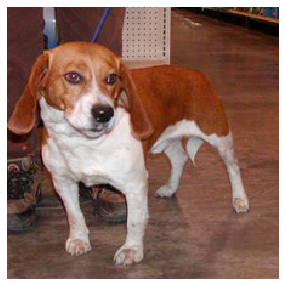

In [40]:
#noexport
if test_example:
    #example = d_sub.iloc[splitter(d_sub)[1]].iloc[4582]
    example = d_sub.iloc[1000]
    print(label_double_func(example))
    print(label_triple_func(example))
    print(label_quatr_func(example))
    print(example)
    pati = get_x(example)
    show_image(pati)
        

In [41]:

tissue_stats =  ([0.6365042 , 0.4866035 , 0.66030514],[0.2311546 , 0.27366328, 0.19013868]) #EPICOLON TUM+STR+LYM selected
#tissue_stats =  ([0.7700158 , 0.6154052 , 0.74566764],[0.19486967, 0.26420233, 0.19368471]) #TSR-CRC + NCT-CRC-HE
#tissue_stats = ([0.6698, 0.5181, 0.6594], [0.2080, 0.2573, 0.1874]) #TCGA svs  
#tissue_stats = ([0.6865583 , 0.5289199 , 0.66556716], [0.20485608, 0.2561432 , 0.18819469]) #TCGA svs TUM+STR+LYM selected
tissue_stats

([0.6365042, 0.4866035, 0.66030514], [0.2311546, 0.27366328, 0.19013868])

In [42]:
_d_sub = d_sub#.sample(frac=.01)


In [43]:
_d_sub.bias_label.value_counts(dropna=False)

20    4070
10     276
11     256
Name: bias_label, dtype: int64

In [44]:
label_bias_func

<function __main__.label_bias_func(r)>

In [45]:
#def img2tensor(im: Image.Image): return TensorImage(array(im)[None])
patient_classes = L(sorted(set(_d_sub.patient_ID.unique())))
TMA_classes = L(sorted(set(_d_sub.tif_fn.unique())))

tfms = [[get_x],
       [label_func, Categorize(vocab = ['MSS', 'MSI'], sort = False)],
       [label_bias_func, Categorize(vocab = ['Other', 'HGUA', 'TCGA'], sort = False)],
       [label_bias1_func, Categorize(vocab = patient_classes, sort = False)],
       [label_bias2_func, Categorize(vocab = TMA_classes, sort = False)],
       ]
train_ds = Datasets(_d_sub[_d_sub.valid == 0],tfms,n_inp=1)
valid_ds = Datasets(_d_sub[_d_sub.valid == 1],tfms,n_inp=1)

In [46]:
#noexport
example = 5
xd,yd, yd1, yd2, yd3 = decode_at(train_ds,example)
xd.shape,yd, yd1, yd2, yd3

(torch.Size([3, 224, 224]), 'MSS', 'Other', '1096', 'TMA06-05')

In [47]:
decode_at(train_ds, example)

(TensorImage([[[0.6445, 0.5977, 0.5312,  ..., 0.6992, 0.6992, 0.6992],
          [0.5625, 0.6094, 0.6094,  ..., 0.6992, 0.6992, 0.6992],
          [0.5078, 0.6094, 0.6562,  ..., 0.7031, 0.7031, 0.7031],
          ...,
          [0.7148, 0.7148, 0.7148,  ..., 0.5430, 0.5430, 0.5430],
          [0.7109, 0.7148, 0.7148,  ..., 0.5391, 0.5391, 0.5391],
          [0.7109, 0.7109, 0.7148,  ..., 0.5352, 0.5352, 0.5391]],
 
         [[0.6250, 0.5820, 0.5234,  ..., 0.7422, 0.7422, 0.7422],
          [0.5430, 0.5977, 0.5977,  ..., 0.7422, 0.7422, 0.7422],
          [0.4883, 0.5898, 0.6406,  ..., 0.7461, 0.7461, 0.7461],
          ...,
          [0.7227, 0.7227, 0.7227,  ..., 0.5820, 0.5820, 0.5820],
          [0.7188, 0.7227, 0.7227,  ..., 0.5781, 0.5781, 0.5781],
          [0.7188, 0.7188, 0.7227,  ..., 0.5742, 0.5742, 0.5781]],
 
         [[0.5469, 0.5078, 0.4609,  ..., 0.7266, 0.7266, 0.7266],
          [0.4609, 0.5195, 0.5352,  ..., 0.7266, 0.7266, 0.7266],
          [0.4023, 0.5117, 0.5742, 

In [48]:
#noexport
x,y,y1, y2, y3= train_ds[example]
x.shape,y,y1, y2, y3

(torch.Size([3, 224, 224]),
 TensorCategory(0),
 TensorCategory(0),
 TensorCategory(106),
 TensorCategory(3))

In [49]:
train_ds

(#3669) [(TensorImage([[[0.8594, 0.5586, 0.5625,  ..., 0.5117, 0.4492, 0.4375],
         [0.8906, 0.5703, 0.5781,  ..., 0.3438, 0.3242, 0.3281],
         [0.8867, 0.5117, 0.5000,  ..., 0.4492, 0.4336, 0.3984],
         ...,
         [0.9922, 0.9727, 0.9492,  ..., 0.9141, 0.8984, 0.9023],
         [0.9961, 0.9766, 0.9609,  ..., 0.9297, 0.9219, 0.9219],
         [0.9961, 0.9883, 0.9805,  ..., 0.9688, 0.9609, 0.9570]],

        [[0.8086, 0.4844, 0.4453,  ..., 0.3945, 0.3320, 0.3203],
         [0.8086, 0.4570, 0.4297,  ..., 0.2188, 0.1992, 0.2031],
         [0.7891, 0.3789, 0.3281,  ..., 0.3281, 0.3086, 0.2734],
         ...,
         [0.9844, 0.9570, 0.9375,  ..., 0.9258, 0.9102, 0.9102],
         [0.9922, 0.9727, 0.9531,  ..., 0.9336, 0.9258, 0.9297],
         [0.9961, 0.9961, 0.9844,  ..., 0.9727, 0.9648, 0.9609]],

        [[0.7539, 0.4102, 0.3438,  ..., 0.3164, 0.2539, 0.2422],
         [0.7266, 0.3555, 0.2891,  ..., 0.1328, 0.1133, 0.1172],
         [0.6992, 0.2617, 0.1758,  ..., 0.2

In [50]:
#noexport
#show_at(train_ds, 0)

In [51]:
#noexport
timg = x
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

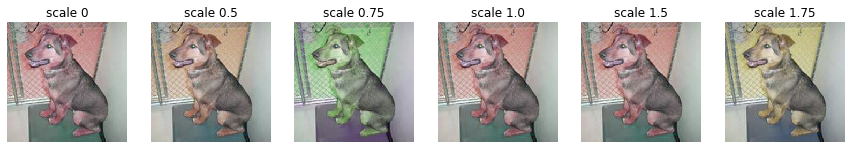

In [52]:
#noexport
scales = [0,0.5, 0.75, 1., 1.5, 1.75]
y = _batch_ex(len(scales)).saturation(max_lighting= 0.4, p=1., )
y = _batch_ex(len(scales)).hue(max_hue= 0.15, p=1., )
fig,axs = plt.subplots(1,len(scales), figsize=(15,3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

In [53]:
bs = 4* a.bs * torch.cuda.device_count()
print(f'batch size= {bs}')
#aug = aug_transforms(mult=2, flip_vert=True, max_rotate=90., min_zoom=0.5, max_zoom=5, size = 224)
aug = aug_transforms(mult=1, do_flip=False,flip_vert=False, max_rotate=0., min_zoom=1, max_zoom=1, size = 224,
                 max_lighting=0,p_lighting=0, 
                    xtra_tfms=[Saturation(max_lighting=0.4,p=1), Hue(max_hue = 0.2, p= 1)])
wgts = _d_sub[_d_sub.valid == 0].weights.values

batch size= 128


In [54]:
calculate_stats = False
if calculate_stats:
    train_dl = WeightedDL(train_ds,shuffle=True,bs=5000, device=default_device(),
                     wgts=wgts,)
    valid_dl = WeightedDL(valid_ds,wgts=None,bs=2500)
    dls = DataLoaders(train_dl, valid_dl, device=default_device(), )
    print (dls[0].after_batch)
    bx=dls.one_batch()[0]
    print(bx.min(),bx.max(),bx.mean(dim=[0,2,3]),bx.std(dim=[0,2,3]))
    tissue_stats = (np.array(bx.mean(dim=[0,2,3]).cpu()),np.array(bx.std(dim=[0,2,3]).cpu()))
    print(tissue_stats)

    

In [55]:


train_dl = WeightedDL(train_ds,shuffle=True,bs=bs, num_workers=a.j, 
                      after_batch=[Normalize.from_stats(*tissue_stats), *aug,],
                     device=default_device(),
                     #wgts=wgts,
                     )
valid_dl = TfmdDL(valid_ds,bs=bs,num_workers=a.j,after_batch=[Normalize.from_stats(*tissue_stats)], )
test_dl  = TfmdDL(test_ds,bs=bs,num_workers=a.j,after_batch=[Normalize.from_stats(*tissue_stats)],)

In [56]:
dls = DataLoaders(train_dl, valid_dl, test_dl, device=default_device(), )

In [57]:
#noexport
dls.train.dataset

(#3669) [(TensorImage([[[0.8594, 0.5586, 0.5625,  ..., 0.5117, 0.4492, 0.4375],
         [0.8906, 0.5703, 0.5781,  ..., 0.3438, 0.3242, 0.3281],
         [0.8867, 0.5117, 0.5000,  ..., 0.4492, 0.4336, 0.3984],
         ...,
         [0.9922, 0.9727, 0.9492,  ..., 0.9141, 0.8984, 0.9023],
         [0.9961, 0.9766, 0.9609,  ..., 0.9297, 0.9219, 0.9219],
         [0.9961, 0.9883, 0.9805,  ..., 0.9688, 0.9609, 0.9570]],

        [[0.8086, 0.4844, 0.4453,  ..., 0.3945, 0.3320, 0.3203],
         [0.8086, 0.4570, 0.4297,  ..., 0.2188, 0.1992, 0.2031],
         [0.7891, 0.3789, 0.3281,  ..., 0.3281, 0.3086, 0.2734],
         ...,
         [0.9844, 0.9570, 0.9375,  ..., 0.9258, 0.9102, 0.9102],
         [0.9922, 0.9727, 0.9531,  ..., 0.9336, 0.9258, 0.9297],
         [0.9961, 0.9961, 0.9844,  ..., 0.9727, 0.9648, 0.9609]],

        [[0.7539, 0.4102, 0.3438,  ..., 0.3164, 0.2539, 0.2422],
         [0.7266, 0.3555, 0.2891,  ..., 0.1328, 0.1133, 0.1172],
         [0.6992, 0.2617, 0.1758,  ..., 0.2

In [58]:
#noexport
dls.train.one_batch()

(TensorImage([[[[-1.5689, -1.4996, -1.4491,  ..., -2.0353, -2.0086, -1.9944],
           [-1.6627, -1.6111, -1.4973,  ..., -1.9925, -1.9692, -1.9647],
           [-1.7404, -1.7088, -1.5763,  ..., -1.9486, -1.9323, -1.9445],
           ...,
           [-0.3101, -0.5736, -0.4743,  ..., -0.5062, -0.5560, -0.5906],
           [-0.3202, -0.4884, -0.6332,  ..., -0.5769, -0.6022, -0.6252],
           [-0.3638, -0.3779, -0.5353,  ..., -0.6050, -0.6312, -0.6505]],
 
          [[-0.9627, -0.9257, -0.8904,  ..., -1.1429, -1.1203, -1.1083],
           [-1.0319, -1.0139, -0.9409,  ..., -1.1067, -1.0871, -1.0833],
           [-1.0865, -1.0800, -1.0121,  ..., -1.0696, -1.0558, -1.0662],
           ...,
           [ 0.2452,  0.0204,  0.1043,  ...,  0.1488,  0.1067,  0.0775],
           [ 0.2451,  0.0846, -0.0299,  ...,  0.0890,  0.0676,  0.0482],
           [ 0.2203,  0.1826,  0.0625,  ...,  0.0653,  0.0432,  0.0269]],
 
          [[-2.6432, -2.6299, -2.5954,  ..., -2.7845, -2.7520, -2.7347],
        

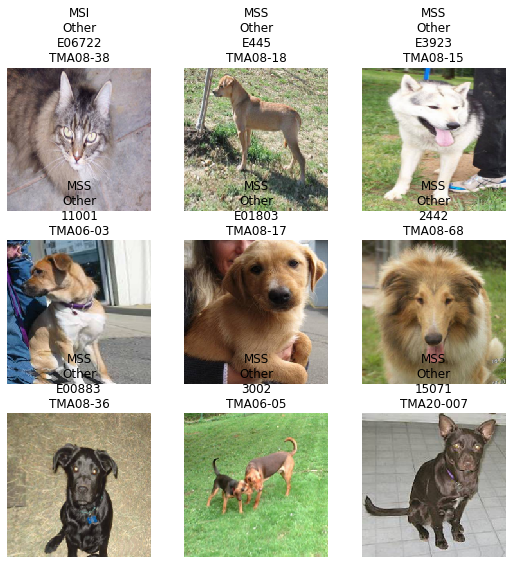

In [59]:
#noexport
dls.show_batch()

In [60]:
#noexport
dls.vocab

(#4) [['MSS', 'MSI'],['Other', 'HGUA', 'TCGA'],['00B0001878', '00B0006471', '00B0012379', '01-08314', '01B0011498', '02B0002433', '02B0009540', '03B0009408', '04B0008943', '04B0009176', '04B0009572', '04B0009739', '05B0003177', '05B0012772', '05B0012976', '06-13251-4', '06-13741', '06B0013741', '06B0014684A', '06B0015316', '06B014684B', '07-002125', '07-02798', '07-06698', '07B0002125', '07B0003469', '07B0004674', '07B0005861', '07B0012609', '07B0012610', '07B0013073', '07B0013077', '07B0015167A', '07B0015167B', '07B0015167C', '07B0015393', '08B0001095', '08B0001097', '08B0001491B', '08B0002498', '08B0004732', '08B0006098B', '08B0006166', '08B0006586', '08B0006591', '08B0006654', '08B0007400', '08B0007717', '1001', '1003', '1005', '1006', '1007', '1008', '1010', '1011', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1023', '1024', '1026', '1027', '1028', '1029', '1031', '1034', '1035', '1037', '1039', '1041', '1042', '1043', '1044', '1046', '1050', '1051', '1052', '10

In [61]:
#noexport
print (dls[0].tfms)
print (dls[0].after_batch)
bx=dls.one_batch()[0]
print(bx.min(),bx.max(),bx.mean(dim=[0,2,3]),bx.std(dim=[0,2,3]))
aug

[Pipeline: get_x, Pipeline: label_func -> Categorize -- {'vocab': ['MSS', 'MSI'], 'sort': False, 'add_na': False}, Pipeline: label_bias_func -> Categorize -- {'vocab': ['Other', 'HGUA', 'TCGA'], 'sort': False, 'add_na': False}, Pipeline: label_bias1_func -> Categorize -- {'vocab': ['00B0001878', '00B0006471', '00B0012379', '01-08314', '01B0011498', '02B0002433', '02B0009540', '03B0009408', '04B0008943', '04B0009176', '04B0009572', '04B0009739', '05B0003177', '05B0012772', '05B0012976', '06-13251-4', '06-13741', '06B0013741', '06B0014684A', '06B0015316', '06B014684B', '07-002125', '07-02798', '07-06698', '07B0002125', '07B0003469', '07B0004674', '07B0005861', '07B0012609', '07B0012610', '07B0013073', '07B0013077', '07B0015167A', '07B0015167B', '07B0015167C', '07B0015393', '08B0001095', '08B0001097', '08B0001491B', '08B0002498', '08B0004732', '08B0006098B', '08B0006166', '08B0006586', '08B0006591', '08B0006654', '08B0007400', '08B0007717', '1001', '1003', '1005', '1006', '1007', '1008', 

TensorImage(-3.4728, device='cuda:0') TensorImage(1.8617, device='cuda:0') TensorImage([-0.8108, -0.2558, -1.4690], device='cuda:0') TensorImage([1.0862, 0.8795, 1.2900], device='cuda:0')


[Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Saturation -- {'max_lighting': 0.4, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 Hue -- {'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

# Model

In [62]:
#noexport
print(Path('models').ls())

[Path('models/segment_tissue_0.4554598927497864_f_acc_0.8807398080825806.pth'), Path('models/segment_tissue_0.3260129690170288_f_acc_0.900049090385437.pth'), Path('models/segment_tissue_presizing0.4628714621067047_f_acc_0.8756903409957886.pth'), Path('models/segment_tissue_presizing0.34281474351882935_f_acc_0.9168598055839539.pth'), Path('models/segment_tissue_9_class_2.2231385707855225_f_acc_nan.pth'), Path('models/segment_tissue_9_class.pth'), Path('models/pretrained_tissue_aug_0.999517653648182.pth'), Path('models/pretrained_tissue_aug_BAC_epicolon0.9993681800971788.pth'), Path('models/MSI_classifier_epicolon_0.8591032422872864.pth'), Path('models/MSI_classifier_epicolon_level_3_0.8562268910196152.pth'), Path('models/MSI_classifier_epicolon_level_2_0.8516107310959105.pth'), Path('models/MSI_classifier_epicolon_level_1_0.8722223505233963.pth'), Path('models/MSI_classifier_epicolon_level_0_0.8644301847354364.pth'), Path('models/MSI_classifier_epicolon_level_0_0.8745365282255746.pth'),

In [63]:
b = dls[0].one_batch()

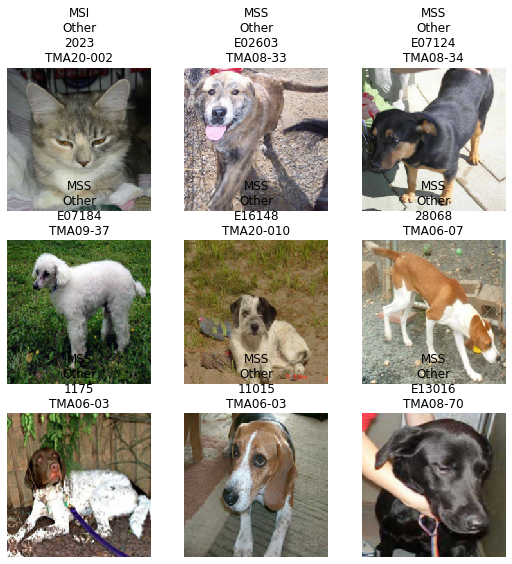

In [64]:
#noexport
dls.show_batch(b)

In [65]:
learn_pretrained = cnn_learner(dls, resnet34, metrics=[RocAuc()],normalize=False, n_out=9,
                                 path=Path("."), pretrained=False, loss_func=CrossEntropyLossFlat())

#learn_pretrained = cnn_learner(dls, vgg16, metrics=[RocAuc()],normalize=False, n_out=9,
                                  #path=Path("."), pretrained=True, loss_func=CrossEntropyLossFlat())

tissue_model = 'pretrained_tissue_aug_BAC_epicolon0.9993681800971788'

learn_pretrained.load(tissue_model)
m_tissue_classifier =  learn_pretrained.model


    


In [66]:
#noexport
if test_example: #visually check tissue type classification in loaded dataset (TODO: check odd behaviour as all the samples were previously selected as TUM)
    #x = torch.randn(2,3,300,300)
    bx = b[0]
    _preds = m_tissue_classifier(bx.cpu())
    #print(preds)
    preds = torch.argmax(nn.Softmax(dim=-1)(_preds), dim = -1)
    #print(preds)
    classes = [cls[i] for i in preds]
    print(classes[:9])
    print(preds)

['MUS', 'MUS', 'BAC', 'DEB', 'STR', 'DEB', 'ADI', 'MUS', 'MUS']
TensorImage([5, 5, 1, 2, 7, 2, 0, 5, 5, 4, 2, 7, 1, 5, 1, 8, 0, 5, 2, 4, 6, 2, 5, 1,
        8, 2, 8, 2, 4, 5, 7, 6, 7, 6, 2, 6, 5, 5, 1, 6, 2, 2, 4, 8, 5, 0, 5, 2,
        8, 8, 8, 5, 5, 8, 7, 8, 8, 2, 8, 4, 1, 5, 5, 5, 6, 5, 1, 8, 1, 4, 4, 8,
        5, 8, 5, 2, 4, 5, 2, 8, 4, 1, 1, 1, 5, 2, 1, 5, 6, 4, 4, 1, 6, 1, 1, 6,
        5, 5, 0, 0, 2, 8, 2, 0, 4, 5, 5, 7, 7, 6, 7, 5, 0, 0, 7, 7, 4, 8, 8, 7,
        8, 7, 2, 6, 7, 2, 2, 8])


In [67]:
class DropBiasInXY(Callback):
    run_train = False
    def after_pred(self):
        if isinstance(self.learn.pred,tuple) and len(self.learn.pred)>1:
            self.learn.pred = self.learn.pred[0],self.learn.pred[1] 
        if isinstance(self.learn.yb,tuple) and len(self.learn.yb)>1:
            self.learn.yb   = (self.learn.yb[0],)
            

#noexport
learn_pretrained.metrics = []
res = learn_pretrained.get_preds(cbs=[DropBiasInXY()])

#noexport
res[0][:10]

In [68]:
mk_class('ActivationType', **{o:o.lower() for o in ['No', 'Sigmoid', 'Softmax', 'BinarySoftmax']},
         doc="All possible activation classes for `AccumMetric")

@patch
def accumulate(self:AccumMetric, learn):
    "Store targs and preds from `learn`, using activation function and argmax as appropriate"
    pred = learn.pred[0] #ignore features...
    if self.activation in [ActivationType.Softmax, ActivationType.BinarySoftmax]:
        pred = F.softmax(pred, dim=self.dim_argmax)
        if self.activation == ActivationType.BinarySoftmax: pred = pred[:, -1]
    elif self.activation == ActivationType.Sigmoid: pred = torch.sigmoid(pred)
    elif self.dim_argmax: pred = pred.argmax(dim=self.dim_argmax)
    if self.thresh:  pred = (pred >= self.thresh)
    self.accum_values(pred,learn.y[0],learn)


@patch
def __accum_values(self:AccumMetric, preds, targs,learn=None):
    "Store targs and preds"
    to_d = learn.to_detach if learn is not None else to_detach
    print(preds,targs)
    preds,targs = to_d(preds[0]),to_d(targs)
    print(preds,targs)
    keep = targs != -100
    preds,targs = preds[keep],targs[keep]
    if preds.numel() == 0: return
    if self.flatten: preds,targs = flatten_check(preds,targs)
    self.preds.append(preds)
    self.targs.append(targs)
    

In [69]:
from fastai.fp16_utils import convert_network
class PutYinX(Callback):
    def __init__(self,m_tissue_classifier): 
        self.tissue_classifier = m_tissue_classifier
        self.tissue_classifier.eval().cuda()
    def before_batch(self):
        #self.learn.xb = self.learn.xb[0],self.learn.xb[1], self.learn.xb[1]
        pass
    def after_pred(self):
        if self.learn.y is None: return
        with torch.no_grad():
            tissue_class = convert_network(self.tissue_classifier,x.dtype)(self.x)
        tissue_class = torch.argmax(nn.Softmax(dim=1)(tissue_class), dim = 1)
        def change(t,cond):
            t[cond]=-100
            return t
        self.learn.yb = apply(partial(change,cond=tissue_class <= 1 ),self.learn.yb)

In [70]:

class TissueBackbone(Module ):
    def __init__(self, m_tissue_classifier ):
        
        self.force_msi = False
        #self.force_fe = False
        
        self.feature_extractor = nn.Sequential( # feature extractor
            nn.ModuleList(m_tissue_classifier.children())[0],
            AdaptiveConcatPool2d(1),
            Flatten(full=False),             
            ).cuda()
        
        self.msi_classifier = nn.Sequential(
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=False),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=2, bias=False)).cuda()
        
        self.bias_classifier = nn.Sequential(
            #AdaptiveConcatPool2d(1),
            #Flatten(full=False),
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=False),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=2, bias=False)).cuda()
        
        self.bias1_classifier = nn.Sequential(
            #AdaptiveConcatPool2d(1),
            #Flatten(full=False), 
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=False),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=1880, bias=False)).cuda()
        
        self.bias2_classifier = nn.Sequential(
            #AdaptiveConcatPool2d(1),
            #Flatten(full=False), 
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=False),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=62, bias=False)).cuda()
    
    def forward(self, x, _forward=None):
        if _forward is not None: return getattr(self,_forward)(x)
        
        fe = self.feature_extractor(x)
        pred_msi = self.msi_classifier(fe)
        if self.force_msi: return pred_msi
        pred_bias = self.bias_classifier(fe)
        pred_bias1 = self.bias1_classifier(fe)
        pred_bias2 = self.bias2_classifier(fe)
        
        #if self.force_fe: return fe
        #if self.force_msi or not self.train: return pred_msi
        
        return (pred_msi, fe, pred_bias, pred_bias1, pred_bias2)


In [71]:
print('2 = MSS , 1 = MSI ,  0 = Others,  1 = HGUA')
if a.dataset == 'epicolon' and a.weight == 'bias_label':
   

    print(_d_sub.bias_label.value_counts())
else:
    print(_d_sub.label.value_counts())



2 = MSS , 1 = MSI ,  0 = Others,  1 = HGUA
20    4070
10     276
11     256
Name: bias_label, dtype: int64


In [72]:

# adversial loss for squared correlation 
def correlation_coefficient_loss0(y_pred, y_true):
    num_classes = y_pred.shape[-1]
    keep = y_true != -100
    x,y = y_pred[keep],y_true[keep]
    
    
    y = torch.nn.functional.one_hot(y, num_classes = num_classes)
    y = y.float()
    x = x.float()
    
    y = F.softmax(y, dim=-1)
    x = F.softmax(x, dim=-1)
    
    y = y.flatten()
    x = x.flatten()
   
    ep = 1e-3
    vx = x - torch.mean(x) 
    vy = y - torch.mean(y)
    
    r = torch.sum(vx * vy) / ((torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))) + ep) 
    
    #r = torch.maximum(torch.minimum(r, torch.tensor(1.0)), torch.tensor(-1.0))
    
    
    return r**2

In [73]:
# adversial loss for squared correlation 
def correlation_coefficient_loss1(y_pred, y_true):
    num_classes = y_pred.shape[-1]
    keep = y_true != -100
    x,y = y_pred[keep],y_true[keep]
    
    
    y = torch.nn.functional.one_hot(y, num_classes = num_classes)
    y = y.float()
    x = x.float()
    
    y = F.softmax(y, dim=-1)
    x = F.softmax(x, dim=-1)
    
    y = y.flatten()
    x = x.flatten()
    
    
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    r = cos(x - x.mean(dim=0, keepdim=True), y - y.mean(dim=0, keepdim=True))
    
    r = r**2
    
    
    return r

In [74]:
# adversial loss for squared correlation 
def correlation_coefficient_loss(y_pred, y_true):
    y = y_true.float()
    x = y_pred.float()
    x = F.softmax(x, dim=-1)
    x = x[:,-1].squeeze() #only correct for two classes
    
    
    keep = y != -100
    x,y = x[keep],y[keep]
    #print(x)
    #print(x.shape)
    #print(y.shape)
    ep = 1e-3
    vx = x - torch.mean(x) 
    vy = y - torch.mean(y)
    
    r = torch.sum(vx * vy) / ((torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))) + ep) 
    
    
    #r = torch.maximum(torch.minimum(r, torch.tensor(1.0)), torch.tensor(-1.0))
    
    return r**2

In [75]:
y_true = torch.tensor([1, 0, -100, 0])
y_true = torch.tensor([0, 1, -100, 1])
y_true = torch.tensor([0, 1, -100, 1])
y_pred = torch.tensor([[5, -2], [-7, -2], [-7, -2], [-7, -2]])

y_true = torch.tensor([0, 0, 0, 0])
y_pred = torch.tensor([[5, -2], [5, -2], [5, -2], [5, -2]])

y_true = torch.tensor([-100, 0, 0, 2])
#y_true = torch.tensor([0, 0, 0, 0])
y_pred = torch.tensor([[0, 1,0], [0, 0,1], [1, 0,0], [0, 0,1]])


y_true = torch.tensor([1, 0, -100, 0])
#y_true = torch.tensor([0, 1, -100, 1])
#y_true = torch.tensor([[0,1], [1,0], [-100,-100], [1,0]]) multiclass
y_pred = torch.tensor([[5, -2], [-7, -2], [-7, -2], [-7, -2]])



In [76]:
#noexport

y_true = torch.tensor([1, 0, -100, 0])
y_true = torch.tensor([0, 1, -100, 1])
y_true = torch.tensor([0, 1, -100, 1])
y_pred = torch.tensor([[5, -2], [-7, -2], [-7, -2], [-7, -2]])

print(y_true)
print(f'original: {correlation_coefficient_loss(y_pred, y_true)}, mod_original:  {correlation_coefficient_loss0(y_pred, y_true)},  cos: {correlation_coefficient_loss1(y_pred, y_true)}')

ce = nn.CrossEntropyLoss()
print(f'crossentropy: {ce(y_pred.float(), y_true)}')



tensor([   0,    1, -100,    1])
original: 0.9969836473464966, mod_original:  0.9970629215240479,  cos: 0.9999696016311646
crossentropy: 0.0047807046212255955


In [77]:
#bias-extracted features correlation function
def feat_target_corr(f, t):
    feat = torch.flatten(f, start_dim=1)
    feat = np.array(feat.cpu())
    targ = np.array(t.cpu())
    dc = dcor.u_distance_correlation_sqr(feat,targ)
    
    return dc

In [78]:

correlations = []
losses = []

from torch.autograd import Variable
@patch
def _do_one_batch(self:Learner):
    
    features = None
    lambda_coef = 10.
    iteration = self.iter + (self.epoch * self.n_iter )
    
    for child in self.model.children():
        for param in child.parameters(): 
            param.requires_grad = True
    
    self.pred = self.model(*self.xb);                self('after_pred')
    bias_pred = self.pred[2] #self.model(self.pred[1].type_as(self.xb[0]),_forward='bias_classifier')
    
    if len(self.yb) == 0: return
    if not self.training: 
        self.loss = lambda_coef * self.loss_func(self.pred[0], self.yb[0]); self('after_loss')
        return
    else:
        self.loss = lambda_coef * self.loss_func(self.pred[0], self.yb[0]); self('after_loss')
        
    losses.append([iteration,self.loss.item(), 'target_loss'])
    
    
    
    
    self('before_backward')
    self._backward();                                self('after_backward')
    self._step();                                    self('after_step')
    self.opt.zero_grad()
    
    
    if a.verbose:
        features = self.pred[1].detach()
        corrs = []
        for bias in self.yb: corrs.append(feat_target_corr(features, bias))
        print(f'finished 1º training step: MSI-Pred-loss {self.loss}, corrs: {corrs}')
        corrs.insert( 0, iteration)
        correlations.append([corrs])
        #------------- record bias loss ------#
        
        bias_loss = 1 - correlation_coefficient_loss(bias_pred, self.yb[1])
        losses.append([iteration,bias_loss.item(), 'bias1_loss'])
        #------------------------------------#
        
        
    if ((a.distillation_start /100) * self.n_iter > self.iter * (self.epoch + 1)) : return
    
    #---------------------------------------------------------------------#
    if (1 in a.control_bias): 
        #conditioning target: stratify bias-pred by MSI status to avoid untoward learning from MSS status: select only one class (MSI +) as it represents evenly both HGUA and Others samples on this dls  
        cond_target = self.yb[1] #In Hospital target --> 
        cond_target[self.yb[0] == 0] = -100 #ablate MSS samples (coded 0)
        if True:
            for child in self.model.feature_extractor.children():
                for param in child.parameters(): param.requires_grad = False
            #features = self.model.feature_extractor(*self.xb)    
            features = self.model(*self.xb,_forward='feature_extractor')    

            for child in self.model.bias_classifier.children():
                for param in child.parameters(): param.requires_grad = True

            #self.pred = self.model.bias_classifier(features);                self('after_pred')
            self.pred = self.model(features,_forward='bias_classifier');                self('after_pred')
            #if len(self.yb[1]) == 0: return

            #self.loss =  self.loss_func(self.pred, cond_target); self('after_loss')
            self.loss = 1 - correlation_coefficient_loss(self.pred, cond_target); self('after_loss')

            losses.append([iteration,self.loss.item(), 'bias1_loss'])


            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 2º training step: Bias-Pred {self.loss}')  
        #---------------------------------------------------------------------# 
        if (self.iter % a.distillation_period == 0):

            for child in self.model.feature_extractor.children():
                for param in child.parameters():
                        param.requires_grad = True
            for child in self.model.bias_classifier.children():
                for param in child.parameters():
                        param.requires_grad = False

            self.pred = self.model(*self.xb);                self('after_pred')
            if len(self.yb[1]) == 0: return



            #self.loss = lambda_coef * correlation_coefficient_loss1(self.pred[1], cond_target); self('after_loss') tontainas
            self.loss =  lambda_coef * correlation_coefficient_loss(self.pred[2], cond_target); self('after_loss')
            
            if not self.training: return
            

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 3º training step: Bias-Distillator {self.loss}')
        #---------------------------------------------------------------------#    
    
    if (2 in a.control_bias):
        #conditioning target: stratify bias-pred by MSI status to avoid untoward learning from MSI status: select only one class (MSS )   
        cond_target = self.yb[2] #Bias1  
        cond_target[self.yb[0] == 1] = -100 #ablate MSI samples (coded 1)
        if True:
            for child in self.model.feature_extractor.children():
                for param in child.parameters(): param.requires_grad = False
            #features = self.model.feature_extractor(*self.xb)    
            features = self.model(*self.xb,_forward='feature_extractor')    

            for child in self.model.bias1_classifier.children():
                for param in child.parameters(): param.requires_grad = True




            self.pred = self.model(features,_forward='bias1_classifier');                self('after_pred')
            if len(self.yb[2]) == 0: return

            

            #self.loss =  self.loss_func(self.pred, cond_target); self('after_loss')
            self.loss = 1 - correlation_coefficient_loss1(self.pred, cond_target); self('after_loss')
            losses.append([iteration,self.loss.item(),  'bias2_loss'])

            if not self.training: return

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 4º training step: Bias1-Pred {self.loss}')            
        #---------------------------------------------------------------------# 
        if (self.iter % a.distillation_period == 0):

            for child in self.model.feature_extractor.children():
                for param in child.parameters():
                        param.requires_grad = True
            for child in self.model.bias1_classifier.children():
                for param in child.parameters():
                        param.requires_grad = False

            self.pred = self.model(*self.xb);                self('after_pred')
            if len(self.yb[2]) == 0: return



            self.loss = lambda_coef * correlation_coefficient_loss1(self.pred[3], cond_target); self('after_loss')
            #self.loss = - self.loss_func(self.pred[2].float(), cond_target); self('after_loss')
            if not self.training: return

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 5º training step: Bias1-Distillator {self.loss}')
          #---------------------------------------------------------------------#    
    
    if (3 in a.control_bias):
        #conditioning target: stratify bias-pred by MSI status to avoid untoward learning from MSI status: select only one class (MSS )   
        cond_target = self.yb[3] #Bias2 
        cond_target[self.yb[0] == 1] = -100 #ablate MSI samples (coded 1)

        if True:
            for child in self.model.feature_extractor.children():
                for param in child.parameters(): param.requires_grad = False
            #features = self.model.feature_extractor(*self.xb)    
            features = self.model(*self.xb,_forward='feature_extractor')    

            for child in self.model.bias2_classifier.children():
                for param in child.parameters(): param.requires_grad = True




            self.pred = self.model(features,_forward='bias2_classifier');                self('after_pred')
            if len(self.yb[3]) == 0: return

            
            self.loss = 1 - correlation_coefficient_loss1(self.pred, cond_target); self('after_loss')
            losses.append([iteration,self.loss.item(),  'bias3_loss'])

            if not self.training: return

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 6º training step: Bias2-Pred {self.loss}')            
        #---------------------------------------------------------------------# 
        if (self.iter % a.distillation_period == 0):

            for child in self.model.feature_extractor.children():
                for param in child.parameters():
                        param.requires_grad = True
            for child in self.model.bias2_classifier.children():
                for param in child.parameters():
                        param.requires_grad = False

            self.pred = self.model(*self.xb);                self('after_pred')
            if len(self.yb[3]) == 0: return



            self.loss = lambda_coef * correlation_coefficient_loss1(self.pred[4], cond_target); self('after_loss')
            if not self.training: return

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 7º training step: Bias2-Distillator {self.loss}')
        #---------------------------------------------------------------------#    



In [79]:
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    
    pred,targ = flatten_check(inp[0].argmax(dim=axis), targ[0])
    return (pred == targ).float().mean()

fastai.metrics.accuracy = accuracy

In [80]:
learn_path = Path('models/no_mazenko')
#learn_path = Path('.')

In [81]:
tissue_backbone = True
if tissue_backbone: 
    x = torch.randn(2, 3, 300, 300).cuda()
    m = TissueBackbone(m_tissue_classifier)
    y = m(x)
    
    
    learn = Learner(dls, m, path= learn_path, metrics=[RocAucBinary()], loss_func = CrossEntropyLossFlat(),
                    #cbs=[PutYinX(m_tissue_classifier),DropBiasInXY()])# cbs = CutMix(alpha=1.))
                    cbs = [SaveModelCallback(monitor='roc_auc_score',fname=f'model_fold{a.fold}')])
                    
                   #)#,  

else: 
    learn = cnn_learner(arch=resnet34, #loss_func = CrossEntropyLossFlat,
                dls = dls, metrics=[error_rate, RocAucBinary()
                                   ], normalize=False, cbs=[PutYinX(m_tissue_classifier)])

In [82]:
#noexport
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, SaveModelCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epo

In [83]:
#learn.to_parallel()

In [84]:
#learn.to_fp16()

In [85]:
#learn.dls[0].one_batch()

In [86]:
#learn.validate()



In [87]:
#learn.summary()


In [88]:
if not a.test_saved_model:
    #learn.fit_one_cycle(a.epochs,a.lr)
    learn.fit(a.epochs,0.00001)
    #learn.fit(10,a.lr)


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.872768,7.195343,0.659582,00:17
1,0.926216,6.986490,0.737490,00:16
2,0.771524,6.726192,0.782790,00:16
3,0.627441,6.722434,0.826400,00:16
4,0.901556,6.422012,0.850348,00:16
5,1.153293,6.586409,0.862775,00:16
6,0.959754,6.489879,0.885309,00:16
7,0.939833,6.114134,0.895372,00:16
8,0.902592,6.330276,0.904164,00:16
9,1.033743,5.972580,0.913377,00:16


finished 1º training step: MSI-Pred-loss 8.487006187438965, corrs: [0.032718536860634445, 0.01087665929667662, 0.00747515001542155, -0.006281210037445903]
finished 2º training step: Bias-Pred 0.9744070768356323
finished 3º training step: Bias-Distillator 2.296231985092163
finished 1º training step: MSI-Pred-loss 8.420839309692383, corrs: [0.010830547491416848, 0.015960358930704195, 0.008200375186546033, -0.005485854386668502]
finished 2º training step: Bias-Pred 0.9957929253578186
finished 3º training step: Bias-Distillator 1.7019236087799072
finished 1º training step: MSI-Pred-loss 7.73306941986084, corrs: [0.0005140043233701932, 0.010796269081610943, 0.009296144992487017, -0.006482333602292729]
finished 2º training step: Bias-Pred 0.9999991059303284
finished 3º training step: Bias-Distillator 1.6739885807037354
finished 1º training step: MSI-Pred-loss 7.948024272918701, corrs: [0.012623344890843874, 0.0207920960656636, -0.0029466320564447077, 0.007431929686634709]
finished 2º trainin

finished 3º training step: Bias-Distillator 0.8453471064567566
finished 1º training step: MSI-Pred-loss 6.923436164855957, corrs: [0.023058924731417577, 0.024298048571469076, 0.004598764303845474, -0.006378758042993873]
finished 2º training step: Bias-Pred 0.9489862322807312
finished 3º training step: Bias-Distillator 0.04268251359462738
finished 1º training step: MSI-Pred-loss 7.680709362030029, corrs: [-0.0004794906405294853, -0.003941354037766911, 0.018394620228722913, 0.00013820780268890701]
finished 2º training step: Bias-Pred 0.9697745442390442
finished 3º training step: Bias-Distillator 0.6753185391426086
finished 1º training step: MSI-Pred-loss 7.475013256072998, corrs: [0.015521464482273595, 0.009990891666605762, -0.007408873049788605, 0.005050433477124675]
finished 2º training step: Bias-Pred 0.955499529838562
finished 3º training step: Bias-Distillator 0.6327980756759644
finished 1º training step: MSI-Pred-loss 7.168578624725342, corrs: [0.016450823924206975, -0.004205024101

finished 3º training step: Bias-Distillator 0.010200140997767448
finished 1º training step: MSI-Pred-loss 7.177082061767578, corrs: [0.02056231557930983, 0.019382429770373546, 0.008760030844238298, -0.0037560656300286125]
finished 2º training step: Bias-Pred 0.7594596743583679
finished 3º training step: Bias-Distillator 1.216619610786438
finished 1º training step: MSI-Pred-loss 6.811681747436523, corrs: [0.02607743811119739, 0.01690250642984811, 0.003499992195131538, 0.01646424124150785]
finished 2º training step: Bias-Pred 0.9910102486610413
finished 3º training step: Bias-Distillator 0.6349781155586243
finished 1º training step: MSI-Pred-loss 7.012739658355713, corrs: [0.03323881358073638, 0.015143646615172472, -0.0051057541384232595, 0.006179592672741622]
finished 2º training step: Bias-Pred 0.9998721480369568
finished 3º training step: Bias-Distillator 0.00014074107457417995
finished 1º training step: MSI-Pred-loss 7.519183158874512, corrs: [0.03341951443228627, 0.02101742596334575

finished 3º training step: Bias-Distillator 2.245401382446289
finished 1º training step: MSI-Pred-loss 6.649507522583008, corrs: [0.019752475595350847, 0.011220868197583379, 0.005696201588733006, 0.006195020300712525]
finished 2º training step: Bias-Pred 0.9987776875495911
finished 3º training step: Bias-Distillator 0.6189624071121216
finished 1º training step: MSI-Pred-loss 7.08820915222168, corrs: [0.019150583480179596, 0.005639941921708919, 0.010380536817843256, -0.0007795842096960963]
finished 2º training step: Bias-Pred 0.8284387588500977
finished 3º training step: Bias-Distillator 0.3648494482040405
finished 1º training step: MSI-Pred-loss 7.471104621887207, corrs: [0.015537391598998264, 0.01891153596919541, 0.010051999859079131, 0.013034611498775425]
finished 2º training step: Bias-Pred 0.8454170227050781
finished 3º training step: Bias-Distillator 0.3965449929237366
finished 1º training step: MSI-Pred-loss 7.323473930358887, corrs: [0.01291833214771633, 0.01899981008792534, 0.0

finished 3º training step: Bias-Distillator 5.835200309753418
finished 1º training step: MSI-Pred-loss 6.447524547576904, corrs: [0.04747497885238768, 0.021965769291693367, 0.0024637876126623044, 0.005158278800828939]
finished 2º training step: Bias-Pred 0.9999768137931824
finished 3º training step: Bias-Distillator 0.16470269858837128
finished 1º training step: MSI-Pred-loss 6.855804920196533, corrs: [0.01711970769924894, 0.027512790670145046, 0.012052553216132618, 0.007251187501624355]
finished 2º training step: Bias-Pred 0.919467568397522
finished 3º training step: Bias-Distillator 1.0298038721084595
finished 1º training step: MSI-Pred-loss 6.910243988037109, corrs: [0.005839794058725817, 0.003703948835666019, -0.006455808524098081, -0.004629933976513934]
finished 2º training step: Bias-Pred 0.9030477404594421
finished 3º training step: Bias-Distillator 0.23747003078460693
finished 1º training step: MSI-Pred-loss 6.472186088562012, corrs: [0.006934446648896875, 0.0157275401949813, 0

finished 3º training step: Bias-Distillator 2.4632556438446045
finished 1º training step: MSI-Pred-loss 6.454470634460449, corrs: [0.03276844545569874, 0.02345224461339707, 0.0019113279986739508, -0.009484461262817998]
finished 2º training step: Bias-Pred 0.8428522348403931
finished 3º training step: Bias-Distillator 3.513645887374878
finished 1º training step: MSI-Pred-loss 6.035938262939453, corrs: [0.043914830362296445, 0.03069692598509922, 0.0038072620264329345, 0.0006685024626990711]
finished 2º training step: Bias-Pred 0.9821612238883972
finished 3º training step: Bias-Distillator 0.06234169006347656
finished 1º training step: MSI-Pred-loss 7.193619728088379, corrs: [0.006399652254808354, 0.02177371196666929, 0.0041624850171822075, 0.0021747143900576467]
finished 2º training step: Bias-Pred 0.9738746881484985
finished 3º training step: Bias-Distillator 0.022960426285862923
finished 1º training step: MSI-Pred-loss 6.383689880371094, corrs: [0.017253614279601478, -0.000418701103278

finished 3º training step: Bias-Distillator 0.005884477868676186
finished 1º training step: MSI-Pred-loss 6.8186235427856445, corrs: [0.014382882195732033, 0.04288924786314747, -0.01576880958588878, -0.0009221695441019828]
finished 2º training step: Bias-Pred 0.7936689853668213
finished 3º training step: Bias-Distillator 2.620004415512085
finished 1º training step: MSI-Pred-loss 6.686200141906738, corrs: [0.054446423667000844, 0.04245663251630804, 0.03172781866601323, 0.013440227270779584]
finished 2º training step: Bias-Pred 0.9274762272834778
finished 3º training step: Bias-Distillator 0.1029476672410965
finished 1º training step: MSI-Pred-loss 6.096960067749023, corrs: [0.04349446453572152, 0.027967319157869458, 0.011353776477560168, -0.002046994856746052]
finished 2º training step: Bias-Pred 0.9291356205940247
finished 3º training step: Bias-Distillator 0.6554880738258362
finished 1º training step: MSI-Pred-loss 6.2554779052734375, corrs: [0.050206123629839436, 0.09166509469100843,

finished 3º training step: Bias-Distillator 1.8108725547790527
finished 1º training step: MSI-Pred-loss 6.683932304382324, corrs: [0.018600531009456956, 0.014080021133638923, 0.01690024042185046, 0.01184535603082188]
finished 2º training step: Bias-Pred 0.9999993443489075
finished 3º training step: Bias-Distillator 0.02628026343882084
finished 1º training step: MSI-Pred-loss 6.483532905578613, corrs: [0.023550883175832163, 0.013730887204334217, -0.007012476226564825, 0.010115339822907134]
finished 2º training step: Bias-Pred 0.8858078122138977
finished 3º training step: Bias-Distillator 1.782330870628357
finished 1º training step: MSI-Pred-loss 6.305644989013672, corrs: [0.007387897509328604, 0.01274793201910611, 0.011687701922175043, 0.005196363774545323]
finished 2º training step: Bias-Pred 0.9349775910377502
finished 3º training step: Bias-Distillator 1.0701833963394165
finished 1º training step: MSI-Pred-loss 6.460968971252441, corrs: [0.023462240522756465, 0.037432939971382494, -0

finished 3º training step: Bias-Distillator 0.03091699443757534
finished 1º training step: MSI-Pred-loss 6.122199058532715, corrs: [0.03891092422281365, 0.013345870111434262, -0.006956252200538935, 0.017602870239681063]
finished 2º training step: Bias-Pred 0.9611548185348511
finished 3º training step: Bias-Distillator 0.06054460629820824
finished 1º training step: MSI-Pred-loss 5.769582748413086, corrs: [0.06504089771002441, 0.026212723240076126, 0.013972716680317174, 0.04493010376665579]
finished 2º training step: Bias-Pred 0.9511287212371826
finished 3º training step: Bias-Distillator 0.07517951726913452
finished 1º training step: MSI-Pred-loss 6.046783447265625, corrs: [0.01279617755698839, 0.010757118448095902, -0.0044401022896077705, -0.0058621511675831664]
finished 2º training step: Bias-Pred 0.9895460605621338
finished 3º training step: Bias-Distillator 0.509054958820343
finished 1º training step: MSI-Pred-loss 6.084979057312012, corrs: [0.046488259156626514, 0.03212983221819417

finished 3º training step: Bias-Distillator 0.7769912481307983
finished 1º training step: MSI-Pred-loss 5.916143417358398, corrs: [0.0538272576086271, 0.030192546069556552, -0.004655087391184124, 0.012841485513540092]
finished 2º training step: Bias-Pred 0.9999685883522034
finished 3º training step: Bias-Distillator 0.7791221737861633
finished 1º training step: MSI-Pred-loss 5.491625785827637, corrs: [0.0840543515796162, 0.06565478782003203, 0.019399091483578206, 0.02733153599895749]
finished 2º training step: Bias-Pred 0.9819782972335815
finished 3º training step: Bias-Distillator 0.835030734539032
finished 1º training step: MSI-Pred-loss 6.720896244049072, corrs: [0.027482033110126276, 0.016201644208551948, -0.004921367054749087, -0.005512139085308035]
finished 2º training step: Bias-Pred 0.6390194892883301
finished 3º training step: Bias-Distillator 1.1296594142913818
finished 1º training step: MSI-Pred-loss 6.390198707580566, corrs: [0.03164821548048507, 0.03713104183375668, 0.0085

finished 3º training step: Bias-Distillator 0.2631852924823761
finished 1º training step: MSI-Pred-loss 5.833868980407715, corrs: [0.04019856816067686, 0.014360551613184296, -0.005286153554373173, 0.007375455367350764]
finished 2º training step: Bias-Pred 0.9674287438392639
finished 3º training step: Bias-Distillator 0.1396125704050064
finished 1º training step: MSI-Pred-loss 5.310277462005615, corrs: [0.10475414112035221, 0.04137630561582365, 0.007851007760785643, 0.0027738062001563413]
finished 2º training step: Bias-Pred 0.9322896003723145
finished 3º training step: Bias-Distillator 1.204238772392273
finished 1º training step: MSI-Pred-loss 4.795258522033691, corrs: [0.0879415329294128, 0.05639230213340773, 0.03331735788390336, 0.010433184714192459]
finished 2º training step: Bias-Pred 0.9782072901725769
finished 3º training step: Bias-Distillator 0.017572849988937378
finished 1º training step: MSI-Pred-loss 5.33537483215332, corrs: [0.08127911498227366, 0.08015119420095672, 0.00010

finished 3º training step: Bias-Distillator 1.8029308319091797
finished 1º training step: MSI-Pred-loss 5.9123759269714355, corrs: [0.035511222755720474, 0.024481486651480172, 0.005989087691088363, -0.002460040597104042]
finished 2º training step: Bias-Pred 0.9680471420288086
finished 3º training step: Bias-Distillator 0.1601809859275818
finished 1º training step: MSI-Pred-loss 5.902833938598633, corrs: [0.04596022241698801, 0.020504864574607748, -0.008160982061581952, 0.005813679754547661]
finished 2º training step: Bias-Pred 0.9662359952926636
finished 3º training step: Bias-Distillator 0.00019819257431663573
finished 1º training step: MSI-Pred-loss 5.4895782470703125, corrs: [0.06997100361568619, 0.0486479610812316, -0.007009058440198254, 0.009857070309645782]
finished 2º training step: Bias-Pred 0.9656718969345093
finished 3º training step: Bias-Distillator 0.760151743888855
finished 1º training step: MSI-Pred-loss 5.920223712921143, corrs: [0.06815216066957426, 0.05877557675963166

finished 3º training step: Bias-Distillator 0.39273813366889954
finished 1º training step: MSI-Pred-loss 5.84964656829834, corrs: [0.055692691052229175, 0.05272412468036312, 0.0017662219637934213, 0.01368380349338538]
finished 2º training step: Bias-Pred 0.9759387373924255
finished 3º training step: Bias-Distillator 0.3445688486099243
finished 1º training step: MSI-Pred-loss 5.053837299346924, corrs: [0.07437222652673152, 0.07333583241377511, 0.00017516416672956812, 0.009971097168740395]
finished 2º training step: Bias-Pred 0.9121426343917847
finished 3º training step: Bias-Distillator 0.584766149520874
finished 1º training step: MSI-Pred-loss 5.16779899597168, corrs: [0.07803233489739621, 0.07538219395736236, 0.008016443850001453, 0.022007794685661802]
finished 2º training step: Bias-Pred 0.9961680769920349
finished 3º training step: Bias-Distillator 0.8576094508171082
finished 1º training step: MSI-Pred-loss 5.917420864105225, corrs: [0.09705157755980459, 0.08731831124150133, 0.01608

finished 3º training step: Bias-Distillator 0.07700512558221817
finished 1º training step: MSI-Pred-loss 5.073315620422363, corrs: [0.08800732492235418, 0.08228739235124138, 0.01106417519315929, 0.01980736482329168]
finished 2º training step: Bias-Pred 0.9987353086471558
finished 3º training step: Bias-Distillator 0.5158113241195679
finished 1º training step: MSI-Pred-loss 5.885135650634766, corrs: [0.05480851090776842, 0.026294903258687836, 0.03241105337460571, -0.0024077271842824015]
finished 2º training step: Bias-Pred 0.9932309985160828
finished 3º training step: Bias-Distillator 0.16281291842460632
finished 1º training step: MSI-Pred-loss 5.67509126663208, corrs: [0.051391283133581815, 0.04049564262404058, 0.005586026508080921, -0.011250543448935784]
finished 2º training step: Bias-Pred 0.9942605495452881
finished 3º training step: Bias-Distillator 4.8129048347473145
finished 1º training step: MSI-Pred-loss 5.555919647216797, corrs: [0.0741628458512568, 0.053668015856261395, 0.014

finished 3º training step: Bias-Distillator 0.03430012986063957
finished 1º training step: MSI-Pred-loss 5.541348934173584, corrs: [0.05043263025622823, 0.07412251714742553, -0.01259762182497294, -0.005405618753490719]
finished 2º training step: Bias-Pred 0.9639737010002136
finished 3º training step: Bias-Distillator 0.9400402307510376
finished 1º training step: MSI-Pred-loss 4.54369592666626, corrs: [0.1215770294035944, 0.08316634774492158, -0.010751091594607154, -0.012781019411232719]
finished 2º training step: Bias-Pred 0.8717573881149292
finished 3º training step: Bias-Distillator 0.1389855146408081
finished 1º training step: MSI-Pred-loss 4.613441467285156, corrs: [0.08718468528632461, 0.09907046955155291, 0.026467556635954344, -0.006579530452151378]
finished 2º training step: Bias-Pred 0.9599372148513794
finished 3º training step: Bias-Distillator 0.00011627063940977678
finished 1º training step: MSI-Pred-loss 5.697093963623047, corrs: [0.04041706719149874, 0.041019576057143035, 

finished 3º training step: Bias-Distillator 0.07815998047590256
finished 1º training step: MSI-Pred-loss 3.928924798965454, corrs: [0.149370524694782, 0.11528877568812754, -0.00476722548225275, -0.01604330146053781]
finished 2º training step: Bias-Pred 0.9866845011711121
finished 3º training step: Bias-Distillator 0.2703787386417389
finished 1º training step: MSI-Pred-loss 4.399853706359863, corrs: [0.13404517014147205, 0.09827301350341042, 0.03915253609275788, 0.024120110348945192]
finished 2º training step: Bias-Pred 0.966058611869812
finished 3º training step: Bias-Distillator 0.15878978371620178
finished 1º training step: MSI-Pred-loss 4.8649444580078125, corrs: [0.0697751732078039, 0.053889813246685084, 0.010865292673129117, -0.0022365909530154683]
finished 2º training step: Bias-Pred 0.941312313079834
finished 3º training step: Bias-Distillator 0.6320727467536926
finished 1º training step: MSI-Pred-loss 4.609909534454346, corrs: [0.07301469615824152, 0.04530089341385596, -0.00808

finished 3º training step: Bias-Distillator 0.7392776012420654
finished 1º training step: MSI-Pred-loss 3.618556261062622, corrs: [0.1658449595178326, 0.11118789033150027, -0.0024957977749925616, 0.010883366247382733]
finished 2º training step: Bias-Pred 0.9999411106109619
finished 3º training step: Bias-Distillator 0.11390718817710876
finished 1º training step: MSI-Pred-loss 5.227959632873535, corrs: [0.10005480177689463, 0.042942281273236314, -0.0019106847053751623, 0.011380698316268109]
finished 2º training step: Bias-Pred 0.8299640417098999
finished 3º training step: Bias-Distillator 0.10246686637401581
finished 1º training step: MSI-Pred-loss 3.7265820503234863, corrs: [0.1651722680386939, 0.09799181680157304, 0.01676637042425987, -0.0073268730337928715]
finished 2º training step: Bias-Pred 0.9719814658164978
finished 3º training step: Bias-Distillator 0.09783214330673218
finished 1º training step: MSI-Pred-loss 3.932993173599243, corrs: [0.1669484096773849, 0.13560028105884506, 0

finished 3º training step: Bias-Distillator 0.024603988975286484
finished 1º training step: MSI-Pred-loss 3.6698553562164307, corrs: [0.30712831163194526, 0.2582405236558006, 0.017455700620381896, 0.0184499576583148]
finished 2º training step: Bias-Pred 0.9899437427520752
finished 3º training step: Bias-Distillator 1.5113626718521118
finished 1º training step: MSI-Pred-loss 4.817030906677246, corrs: [0.06902213318343568, 0.029107829451707392, 0.016237093247856126, -0.0011596228067000346]
finished 2º training step: Bias-Pred 0.9812349081039429
finished 3º training step: Bias-Distillator 0.13375161588191986
finished 1º training step: MSI-Pred-loss 3.9662442207336426, corrs: [0.18185519788331506, 0.12637135868403898, 0.008046530387900057, 0.020541988794083418]
finished 2º training step: Bias-Pred 0.8654199838638306
finished 3º training step: Bias-Distillator 1.2678852081298828
finished 1º training step: MSI-Pred-loss 3.6799252033233643, corrs: [0.15466404047167398, 0.10248513413003185, 0.

finished 3º training step: Bias-Distillator 2.1952157020568848
finished 1º training step: MSI-Pred-loss 2.8294591903686523, corrs: [0.21567339409593042, 0.09491936370259033, 0.011668726937772553, 0.010268419452839952]
finished 2º training step: Bias-Pred 0.830625593662262
finished 3º training step: Bias-Distillator 0.4394534230232239
finished 1º training step: MSI-Pred-loss 3.2917089462280273, corrs: [0.27490349154406263, 0.12378422664928093, 7.564671187188443e-05, 0.027286775647274105]
finished 2º training step: Bias-Pred 0.9935569167137146
finished 3º training step: Bias-Distillator 0.3142699599266052
finished 1º training step: MSI-Pred-loss 3.7545716762542725, corrs: [0.2046516189131985, 0.12671406410898525, 0.009638475820802255, 0.015095873918806034]
finished 2º training step: Bias-Pred 0.9954824447631836
finished 3º training step: Bias-Distillator 1.2351523637771606
finished 1º training step: MSI-Pred-loss 3.2909679412841797, corrs: [0.24077677984195828, 0.1393894959892908, -0.003

finished 3º training step: Bias-Distillator 0.29986512660980225
finished 1º training step: MSI-Pred-loss 2.4829533100128174, corrs: [0.3706984988757343, 0.2427863818391518, 0.008153478943757111, -0.0002501336236101677]
finished 2º training step: Bias-Pred 0.9746864438056946
finished 3º training step: Bias-Distillator 0.26940909028053284
finished 1º training step: MSI-Pred-loss 3.5110270977020264, corrs: [0.170776508281156, 0.15909975910229976, 0.04086452482058978, 0.027761148813486604]
finished 2º training step: Bias-Pred 0.9916862845420837
finished 3º training step: Bias-Distillator 0.07045485824346542
finished 1º training step: MSI-Pred-loss 2.5512490272521973, corrs: [0.2922257340972285, 0.2238311801077208, 0.011326468308194277, 0.07510811987684235]
finished 2º training step: Bias-Pred 0.847330629825592
finished 3º training step: Bias-Distillator 0.8550448417663574
finished 1º training step: MSI-Pred-loss 3.2206497192382812, corrs: [0.27313233788440344, 0.016389210831045997, -0.0016

finished 3º training step: Bias-Distillator 0.1384618729352951
finished 1º training step: MSI-Pred-loss 2.794700860977173, corrs: [0.24079001566202526, 0.2022069903220576, 0.009271270057504666, -0.0008446357566566369]
finished 2º training step: Bias-Pred 0.8096812963485718
finished 3º training step: Bias-Distillator 2.8299787044525146
finished 1º training step: MSI-Pred-loss 2.153379201889038, corrs: [0.4067377479674236, 0.45124662102941127, 0.05746909368420779, 0.004585695050940742]
finished 2º training step: Bias-Pred 0.9215336441993713
finished 3º training step: Bias-Distillator 0.3994387686252594
finished 1º training step: MSI-Pred-loss 2.325977325439453, corrs: [0.46965193022454144, 0.35435599321791733, 0.04084535294291976, 0.0844988166466584]
finished 2º training step: Bias-Pred 0.78980553150177
finished 3º training step: Bias-Distillator 0.2217915803194046
finished 1º training step: MSI-Pred-loss 2.3501954078674316, corrs: [0.3601257748967158, 0.17062111007528286, 0.014429619954

finished 1º training step: MSI-Pred-loss 2.383584976196289, corrs: [0.433282147280012, 0.1696143028721705, 0.00885978080409343, 0.03476210928693733]
finished 2º training step: Bias-Pred 0.9498472809791565
finished 3º training step: Bias-Distillator 0.002659653313457966
finished 1º training step: MSI-Pred-loss 2.302595615386963, corrs: [0.3290581938580168, 0.20559112372051205, 0.016893618015144034, 0.01433101031883447]
finished 2º training step: Bias-Pred 0.8114609122276306
finished 3º training step: Bias-Distillator 1.0821725130081177
finished 1º training step: MSI-Pred-loss 2.294962167739868, corrs: [0.342581183565274, 0.3545800448895057, 0.02212533426556161, 0.02079840730485543]
finished 2º training step: Bias-Pred 0.6562521457672119
finished 3º training step: Bias-Distillator 1.9626619815826416
finished 1º training step: MSI-Pred-loss 1.82753324508667, corrs: [0.4519501793063366, 0.23787389943669163, 0.004374007997246952, -0.0011584213210784804]
finished 2º training step: Bias-Pred 

finished 3º training step: Bias-Distillator 0.3201420307159424
finished 1º training step: MSI-Pred-loss 1.3451497554779053, corrs: [0.5801217735589129, 0.12802190172559635, -0.00290868538025195, 0.0017242014728937078]
finished 2º training step: Bias-Pred 0.9797636270523071
finished 3º training step: Bias-Distillator 1.4298410415649414
finished 1º training step: MSI-Pred-loss 2.740903377532959, corrs: [0.4017128989139765, 0.1830571892394832, -0.010275866584138595, 0.018022327039973907]
finished 2º training step: Bias-Pred 0.8227421045303345
finished 3º training step: Bias-Distillator 0.4480666518211365
finished 1º training step: MSI-Pred-loss 2.0161118507385254, corrs: [0.4386884790490802, 0.20450389669242616, 0.006997609721234309, 0.046220439800975635]
finished 2º training step: Bias-Pred 0.9898978471755981
finished 3º training step: Bias-Distillator 0.09307555854320526
finished 1º training step: MSI-Pred-loss 2.2105062007904053, corrs: [0.42285901121234387, 0.12121284859656549, 0.0027

finished 3º training step: Bias-Distillator 0.0522938035428524
finished 1º training step: MSI-Pred-loss 1.2223262786865234, corrs: [0.517969390340445, 0.3439711473980382, 0.06422493146300003, 0.029363857583533652]
finished 2º training step: Bias-Pred 0.9783923029899597
finished 3º training step: Bias-Distillator 0.47396016120910645
finished 1º training step: MSI-Pred-loss 2.053393840789795, corrs: [0.4324660988761361, 0.1598730621582401, 0.06959590289448314, 0.044882472616386664]
finished 2º training step: Bias-Pred 0.9905561804771423
finished 3º training step: Bias-Distillator 2.0537028312683105
finished 1º training step: MSI-Pred-loss 1.815678596496582, corrs: [0.4663310962122564, 0.6276337316928647, 0.035765992577912964, 0.017574188635415995]
finished 2º training step: Bias-Pred 0.8270034790039062
finished 3º training step: Bias-Distillator 1.5598156452178955
finished 1º training step: MSI-Pred-loss 1.6528332233428955, corrs: [0.5347418310325569, 0.20691337426807677, 0.0312756420186

finished 3º training step: Bias-Distillator 0.527977466583252
finished 1º training step: MSI-Pred-loss 1.7472361326217651, corrs: [0.33974327931326065, 0.1866824222908757, -0.0033072001071768674, 0.020110088398080827]
finished 2º training step: Bias-Pred 0.9821253418922424
finished 3º training step: Bias-Distillator 0.476837158203125
finished 1º training step: MSI-Pred-loss 1.109046220779419, corrs: [0.4479915931171848, 0.14245604084508653, 0.03575225523515469, 0.026298974086516894]
finished 2º training step: Bias-Pred 0.8955329060554504
finished 3º training step: Bias-Distillator 1.044851303100586
finished 1º training step: MSI-Pred-loss 3.2270848751068115, corrs: [0.4725278198389602, 0.24703362942401186, 0.01935204026496461, -0.0026730632087506897]
finished 2º training step: Bias-Pred 0.7944923639297485
finished 3º training step: Bias-Distillator 0.6566422581672668
finished 1º training step: MSI-Pred-loss 1.5284483432769775, corrs: [0.44284125800399915, 0.2333739161951626, 0.04638908

finished 1º training step: MSI-Pred-loss 1.6386300325393677, corrs: [0.5085371995536416, 0.23162345938386358, 0.04110882651192314, 0.0011259603599776406]
finished 2º training step: Bias-Pred 0.8319422006607056
finished 3º training step: Bias-Distillator 2.503528594970703
finished 1º training step: MSI-Pred-loss 1.3130321502685547, corrs: [0.5147964299809262, 0.28363824318409614, 0.003180612824672481, 0.05033839045152413]
finished 2º training step: Bias-Pred 0.9574648141860962
finished 3º training step: Bias-Distillator 0.14303633570671082
finished 1º training step: MSI-Pred-loss 1.4762234687805176, corrs: [0.42273394314560536, 0.144970887453681, -0.003323829758487843, 0.03467698135270321]
finished 2º training step: Bias-Pred 0.9999969601631165
finished 3º training step: Bias-Distillator 0.2421264350414276
finished 1º training step: MSI-Pred-loss 1.4460593461990356, corrs: [0.46951468623778875, 0.36927690780750744, -0.0019886033162886865, 0.04313401547890546]
finished 2º training step: 

finished 1º training step: MSI-Pred-loss 1.624103307723999, corrs: [0.38277056150686867, 0.3197468856593707, 0.006974730340373437, -0.0040253328197797054]
finished 2º training step: Bias-Pred 0.9981788992881775
finished 3º training step: Bias-Distillator 1.8666423559188843
finished 1º training step: MSI-Pred-loss 1.7732537984848022, corrs: [0.4616354979697042, 0.15656989721829023, 0.003217353628038846, 0.028055041979561712]
finished 2º training step: Bias-Pred 0.9977774620056152
finished 3º training step: Bias-Distillator 0.25885340571403503
finished 1º training step: MSI-Pred-loss 1.32523775100708, corrs: [0.46152201650910085, 0.39404690181079527, 0.019473403944033046, 0.0327247764987882]
finished 2º training step: Bias-Pred 0.6809168457984924
finished 3º training step: Bias-Distillator 1.4925552606582642
finished 1º training step: MSI-Pred-loss 0.46945875883102417, corrs: [0.6851255447449043, 0.25726466805421966, 0.014900753711008508, 0.04116949041511834]
finished 2º training step: B

finished 3º training step: Bias-Distillator 0.12513203918933868
finished 1º training step: MSI-Pred-loss 1.215619444847107, corrs: [0.4428688732274779, 0.3461866501637855, 0.018741569784012577, 0.00929437460516968]
finished 2º training step: Bias-Pred 0.1934502124786377
finished 3º training step: Bias-Distillator 8.310051918029785
Better model found at epoch 27 with roc_auc_score value: 0.9667623992046835.
finished 1º training step: MSI-Pred-loss 1.1118634939193726, corrs: [0.47538550041756145, -2.592696549863028e-17, 0.00654960705480421, 0.0010739338350567297]
finished 2º training step: Bias-Pred 0.9950640797615051
finished 3º training step: Bias-Distillator 1.3377985954284668
finished 1º training step: MSI-Pred-loss 0.9066884517669678, corrs: [0.5457335708712194, 0.2657173693792015, 0.03525572553867998, 0.011426027859072905]
finished 2º training step: Bias-Pred 0.9998247623443604
finished 3º training step: Bias-Distillator 0.36905890703201294
finished 1º training step: MSI-Pred-loss 

finished 2º training step: Bias-Pred 0.6052051782608032
finished 3º training step: Bias-Distillator 2.620706081390381
finished 1º training step: MSI-Pred-loss 1.5853251218795776, corrs: [0.43600417790407164, 0.2384706130736453, 0.00849533290049866, -0.006450834178876004]
finished 2º training step: Bias-Pred 0.8090834021568298
finished 3º training step: Bias-Distillator 0.05734425038099289
finished 1º training step: MSI-Pred-loss 0.8908149003982544, corrs: [0.543037706978174, 0.27404733680196763, 0.0049445445585667575, 0.003813180124298724]
finished 2º training step: Bias-Pred 0.9825834035873413
finished 3º training step: Bias-Distillator 1.6739262342453003
finished 1º training step: MSI-Pred-loss 0.8026207089424133, corrs: [0.4755313426527467, 0.21194379313988554, 0.004585849260540387, 0.018119459938420093]
finished 2º training step: Bias-Pred 0.9998767375946045
finished 3º training step: Bias-Distillator 1.1277191638946533
finished 1º training step: MSI-Pred-loss 1.205883502960205, co

finished 3º training step: Bias-Distillator 0.005516132805496454
finished 1º training step: MSI-Pred-loss 0.5344880223274231, corrs: [0.69806077619161, 0.3334737019888293, 0.014877345515567676, 0.06276155678760945]
finished 2º training step: Bias-Pred 0.7975382208824158
finished 3º training step: Bias-Distillator 1.5483157634735107
finished 1º training step: MSI-Pred-loss 1.4759021997451782, corrs: [0.3734337773001285, 0.054554825698084355, 0.003050662257828275, 0.006321375839035181]
finished 2º training step: Bias-Pred 0.9559746980667114
finished 3º training step: Bias-Distillator 2.272646188735962
finished 1º training step: MSI-Pred-loss 2.4046123027801514, corrs: [0.42873525757439535, 0.12703422098675557, -0.006753577663092687, -0.0005242375824868099]
finished 2º training step: Bias-Pred 0.9973673224449158
finished 3º training step: Bias-Distillator 0.0009172942955046892
finished 1º training step: MSI-Pred-loss 0.8184247016906738, corrs: [0.5084493313869023, 0.11947897886505882, 0.0

finished 3º training step: Bias-Distillator 2.23184871673584
finished 1º training step: MSI-Pred-loss 0.7133663296699524, corrs: [0.5605580623943391, 0.14874855673052048, 0.006229448977505929, 0.06123277717473529]
finished 2º training step: Bias-Pred 0.9354615211486816
finished 3º training step: Bias-Distillator 1.148551106452942
finished 1º training step: MSI-Pred-loss 1.1469261646270752, corrs: [0.6294321815211344, 0.2041985408739155, 0.00045373198489651517, 0.026462584514041404]
finished 2º training step: Bias-Pred 0.9932181239128113
finished 3º training step: Bias-Distillator 1.266829252243042
finished 1º training step: MSI-Pred-loss 0.7882261276245117, corrs: [0.5264690220547955, 0.4411396527859207, 0.031591164021099655, 0.016311330850783744]
finished 2º training step: Bias-Pred 0.9954519867897034
finished 3º training step: Bias-Distillator 5.97987174987793
finished 1º training step: MSI-Pred-loss 0.36514219641685486, corrs: [0.7386585772349517, 0.3713961325457385, 0.0833196167971

finished 1º training step: MSI-Pred-loss 0.5032708644866943, corrs: [0.5882030206134641, 0.188127725976306, 0.01126717614053681, 0.06577140503593615]
finished 2º training step: Bias-Pred 0.9878676533699036
finished 3º training step: Bias-Distillator 0.12070923298597336
finished 1º training step: MSI-Pred-loss 0.7816571593284607, corrs: [0.4820034147584332, 0.08950116748413095, 0.003183099425088636, 0.10239150951870092]
finished 2º training step: Bias-Pred 0.9383471012115479
finished 3º training step: Bias-Distillator 1.4371583461761475
finished 1º training step: MSI-Pred-loss 0.5003511309623718, corrs: [0.567268966259984, 0.17914692051534808, -0.005196281247136217, 0.009436265930882667]
finished 2º training step: Bias-Pred 0.8722450733184814
finished 3º training step: Bias-Distillator 3.8525590896606445
finished 1º training step: MSI-Pred-loss 0.7560532689094543, corrs: [0.47271199605643527, 0.23825613418850966, 0.05009634090520896, -0.003871660719453485]
finished 2º training step: Bia

finished 3º training step: Bias-Distillator 0.372626930475235
finished 1º training step: MSI-Pred-loss 0.54039466381073, corrs: [0.617355590092651, 0.1384543114251493, 0.01815653172421062, 0.05886714869792353]
finished 2º training step: Bias-Pred 0.6631278395652771
finished 3º training step: Bias-Distillator 0.10114718973636627
finished 1º training step: MSI-Pred-loss 0.5631101131439209, corrs: [0.6906305581556018, 0.4656755218915444, 0.08488866380568914, 0.02303024278534954]
finished 2º training step: Bias-Pred 0.9111568331718445
finished 3º training step: Bias-Distillator 0.016223357990384102
finished 1º training step: MSI-Pred-loss 0.5375115871429443, corrs: [0.619312584752625, 0.21238997272068882, -0.0014794483940850413, 0.047127476622870874]
finished 2º training step: Bias-Pred 0.9708489179611206
finished 3º training step: Bias-Distillator 3.23472261428833
finished 1º training step: MSI-Pred-loss 0.5950310230255127, corrs: [0.594661005738422, 0.3311520985526381, 0.0422657970510261

finished 3º training step: Bias-Distillator 0.5704587697982788
finished 1º training step: MSI-Pred-loss 0.6868339776992798, corrs: [0.5036892843723965, 0.17840366508874195, -0.0005502487221865954, 0.010070695711451248]
finished 2º training step: Bias-Pred 0.988478422164917
finished 3º training step: Bias-Distillator 2.4036407470703125
finished 1º training step: MSI-Pred-loss 0.6899979114532471, corrs: [0.46856565352517116, 0.2674686451892314, 0.028731983209449013, 0.021176413817834243]
finished 2º training step: Bias-Pred 0.9538134336471558
finished 3º training step: Bias-Distillator 0.6720817685127258
finished 1º training step: MSI-Pred-loss 0.37026453018188477, corrs: [0.5847658582003918, 0.19638727176821924, 0.014852507768235428, 0.010362027021079839]
finished 2º training step: Bias-Pred 0.9997479915618896
finished 3º training step: Bias-Distillator 0.5398802757263184
finished 1º training step: MSI-Pred-loss 0.3655194640159607, corrs: [0.6041452217620236, 0.05922066718070271, -0.008

finished 3º training step: Bias-Distillator 0.00961277261376381
finished 1º training step: MSI-Pred-loss 0.3069194257259369, corrs: [0.7842942279013753, 0.27081883487217123, 0.00038422272939997904, 0.027863267838585566]
finished 2º training step: Bias-Pred 0.8830024003982544
finished 3º training step: Bias-Distillator 0.5596809983253479
finished 1º training step: MSI-Pred-loss 0.1428873986005783, corrs: [0.6974357743049229, 0.354618486264573, 0.03886254185071552, 0.06807436865183378]
finished 2º training step: Bias-Pred 0.9480888843536377
finished 3º training step: Bias-Distillator 0.13646601140499115
finished 1º training step: MSI-Pred-loss 0.34541311860084534, corrs: [0.6910285175663735, 0.19762321191309146, 0.018729720315838368, 0.005146563445729467]
finished 2º training step: Bias-Pred 0.9772546887397766
finished 3º training step: Bias-Distillator 0.08018448203802109
finished 1º training step: MSI-Pred-loss 0.829944372177124, corrs: [0.5160495226729997, 0.347172521437024, 0.0257831

finished 3º training step: Bias-Distillator 0.3716208338737488
finished 1º training step: MSI-Pred-loss 0.6917046904563904, corrs: [0.46088030048037615, 0.3195105722424193, 0.07158569864337873, 0.009244024818291037]
finished 2º training step: Bias-Pred 0.9325136542320251
finished 3º training step: Bias-Distillator 0.9520635604858398
finished 1º training step: MSI-Pred-loss 0.33433109521865845, corrs: [0.6279486633021141, 0.10571010904420763, 0.005751069516527938, 0.05102497044115926]
finished 2º training step: Bias-Pred 0.8136633038520813
finished 3º training step: Bias-Distillator 1.4729619026184082
finished 1º training step: MSI-Pred-loss 0.5530704259872437, corrs: [0.6861351802095271, 0.26863130362630017, -0.006326646829979312, -0.00124626716677784]
finished 2º training step: Bias-Pred 0.6716644763946533
finished 3º training step: Bias-Distillator 0.16638949513435364
finished 1º training step: MSI-Pred-loss 0.8516749143600464, corrs: [0.545214009627974, 0.2680307229276571, -0.003703

finished 3º training step: Bias-Distillator 0.06843014806509018
finished 1º training step: MSI-Pred-loss 0.5776363015174866, corrs: [0.5824021736047028, 0.12354399111446521, 0.027950781156865365, 0.0216819645489534]
finished 2º training step: Bias-Pred 0.9996145963668823
finished 3º training step: Bias-Distillator 0.4889252185821533
finished 1º training step: MSI-Pred-loss 0.6002545952796936, corrs: [0.5579643020730756, 0.05548152786836966, 0.003108171364891761, 0.029462646937958994]
finished 2º training step: Bias-Pred 0.9652227163314819
finished 3º training step: Bias-Distillator 0.0022709621116518974
finished 1º training step: MSI-Pred-loss 0.3618757426738739, corrs: [0.6387853615183894, 0.13226007194775188, -0.0049206000610434175, 0.032448228799011276]
finished 2º training step: Bias-Pred 0.9837808609008789
finished 3º training step: Bias-Distillator 0.15126827359199524
finished 1º training step: MSI-Pred-loss 0.4970266819000244, corrs: [0.6064848311078728, 0.12405571180361544, 0.0

finished 3º training step: Bias-Distillator 0.0011794277234002948
finished 1º training step: MSI-Pred-loss 0.38618308305740356, corrs: [0.6986956306488321, 0.2123661541345766, 0.002624078287553563, 0.04385172027554768]
finished 2º training step: Bias-Pred 0.980566680431366
finished 3º training step: Bias-Distillator 0.11628812551498413
finished 1º training step: MSI-Pred-loss 0.6199323534965515, corrs: [0.5429319430437313, 0.26095641706129946, 0.007363909976610736, 0.026403954006902552]
finished 2º training step: Bias-Pred 0.9969048500061035
finished 3º training step: Bias-Distillator 0.0017827886622399092
finished 1º training step: MSI-Pred-loss 0.34022200107574463, corrs: [0.6165232910807255, 0.27034370288909093, 0.033106384576358054, 0.02802249967126222]
finished 2º training step: Bias-Pred 0.844197154045105
finished 3º training step: Bias-Distillator 0.12894245982170105
finished 1º training step: MSI-Pred-loss 0.35665497183799744, corrs: [0.6506873454728086, 0.2447351586589799, 0.0

finished 3º training step: Bias-Distillator 0.7150255441665649
finished 1º training step: MSI-Pred-loss 0.9338271021842957, corrs: [0.6013176449095283, 0.14542190917648942, 0.0071638347652758505, 0.06040889622475886]
finished 2º training step: Bias-Pred 0.8718695044517517
finished 3º training step: Bias-Distillator 1.7115610837936401
finished 1º training step: MSI-Pred-loss 0.5148690938949585, corrs: [0.7030830542722372, 0.2801698584266982, -0.004022568641638793, 0.1005222904234316]
finished 2º training step: Bias-Pred 0.9081927537918091
finished 3º training step: Bias-Distillator 0.32619622349739075
finished 1º training step: MSI-Pred-loss 1.2056649923324585, corrs: [0.6664164798812842, 0.2560864758608064, 0.013269208048266775, 0.033310269899189664]
finished 2º training step: Bias-Pred 0.9877179265022278
finished 3º training step: Bias-Distillator 2.178013801574707
finished 1º training step: MSI-Pred-loss 0.8341905474662781, corrs: [0.5779098302880059, 0.36537644932255003, 0.046253273

finished 1º training step: MSI-Pred-loss 0.45354101061820984, corrs: [0.6611006509465104, 0.21099085860380157, -0.0007088701283733903, 0.03778992578029666]
finished 2º training step: Bias-Pred 0.9504991769790649
finished 3º training step: Bias-Distillator 4.44265604019165
finished 1º training step: MSI-Pred-loss 0.7732510566711426, corrs: [0.607423497891256, 0.1456322235698164, -0.004161690103673178, 0.02283800848413847]
finished 2º training step: Bias-Pred 0.6613837480545044
finished 3º training step: Bias-Distillator 1.3750686645507812
finished 1º training step: MSI-Pred-loss 0.20282165706157684, corrs: [0.6500564525001717, 0.4268424638792997, 0.014161253237357573, 0.0790996273711694]
finished 2º training step: Bias-Pred 0.9017757773399353
finished 3º training step: Bias-Distillator 0.8187839984893799
finished 1º training step: MSI-Pred-loss 1.045081615447998, corrs: [0.6791734089583022, 0.2643112839807051, 0.009739065621204326, 0.04797445447130805]
finished 2º training step: Bias-Pr

finished 3º training step: Bias-Distillator 0.09196057915687561
finished 1º training step: MSI-Pred-loss 0.6017608642578125, corrs: [0.6386999335293261, 0.23945090744932773, 0.012737561934512249, 0.01575632609480541]
finished 2º training step: Bias-Pred 0.9996583461761475
finished 3º training step: Bias-Distillator 1.1834871768951416
finished 1º training step: MSI-Pred-loss 0.29409605264663696, corrs: [0.6137636282300111, 0.5169486315755183, 0.035014378477864455, 0.01146196204928569]
finished 2º training step: Bias-Pred 0.9923986196517944
finished 3º training step: Bias-Distillator 0.02975439466536045
finished 1º training step: MSI-Pred-loss 0.14197519421577454, corrs: [0.5989124958281455, 0.34140010051799763, 0.053364883937853325, 0.0027066779714458008]
finished 2º training step: Bias-Pred 0.9891440868377686
finished 3º training step: Bias-Distillator 1.6051404476165771
finished 1º training step: MSI-Pred-loss 0.43029072880744934, corrs: [0.616176037368502, 0.3288011249204193, 0.01788

finished 1º training step: MSI-Pred-loss 0.3350541293621063, corrs: [0.7165891938168011, 0.451905736330556, 0.034575237867677654, 0.029665438198300035]
finished 2º training step: Bias-Pred 0.9585004448890686
finished 3º training step: Bias-Distillator 0.1762998253107071
finished 1º training step: MSI-Pred-loss 0.38922661542892456, corrs: [0.7019576395430536, 0.458037112657553, 0.05685577781428992, 0.012837588683204072]
finished 2º training step: Bias-Pred 0.7457778453826904
finished 3º training step: Bias-Distillator 0.09434083104133606
finished 1º training step: MSI-Pred-loss 0.21748946607112885, corrs: [0.6596786493416508, 0.1906546213111314, 0.009279043360473945, 0.09640101282848838]
finished 2º training step: Bias-Pred 0.9957424402236938
finished 3º training step: Bias-Distillator 0.12371434271335602
finished 1º training step: MSI-Pred-loss 0.3784239590167999, corrs: [0.6394966425559432, 0.2277643259260819, 0.00865236711194122, 0.01003447510400244]
finished 2º training step: Bias-P

finished 3º training step: Bias-Distillator 0.011631159111857414
finished 1º training step: MSI-Pred-loss 0.33831265568733215, corrs: [0.6827055410171607, 0.2968764660316865, 0.00307481189168189, 0.05925790798968823]
finished 2º training step: Bias-Pred 0.9980672597885132
finished 3º training step: Bias-Distillator 0.3928683400154114
finished 1º training step: MSI-Pred-loss 0.14419390261173248, corrs: [0.7249501859919355, 0.5402823147373785, 0.0725177273844137, 0.08031062585026129]
finished 2º training step: Bias-Pred 0.943976640701294
finished 3º training step: Bias-Distillator 0.12116629630327225
finished 1º training step: MSI-Pred-loss 0.4971439242362976, corrs: [0.6427538657782809, 0.4106130839936085, 0.05532455385677803, 0.0418348940788492]
finished 2º training step: Bias-Pred 0.8294219970703125
finished 3º training step: Bias-Distillator 1.2909197807312012
finished 1º training step: MSI-Pred-loss 0.26532718539237976, corrs: [0.7078050494459049, 0.3172360746842547, 0.0359218402186

finished 1º training step: MSI-Pred-loss 0.37323030829429626, corrs: [0.6841804742948389, 0.3131820416598873, 0.007879430078800815, -0.003571390155334262]
finished 2º training step: Bias-Pred 0.9891590476036072
finished 3º training step: Bias-Distillator 0.7561182379722595
finished 1º training step: MSI-Pred-loss 0.3256719708442688, corrs: [0.6095285374905216, 0.25768304513703216, -0.0022684418859743455, 0.021090252641399757]
finished 2º training step: Bias-Pred 0.9968738555908203
finished 3º training step: Bias-Distillator 0.0813601091504097
finished 1º training step: MSI-Pred-loss 0.08871451020240784, corrs: [0.7504583407147658, 0.38467244789061417, 0.03335926861468838, 0.025166904801070943]
finished 2º training step: Bias-Pred 0.9697479009628296
finished 3º training step: Bias-Distillator 0.2922120988368988
finished 1º training step: MSI-Pred-loss 0.1057768315076828, corrs: [0.7700933511676632, 0.43327155081101865, 0.04268029112402666, 0.03775517567742808]
finished 2º training step:

finished 3º training step: Bias-Distillator 0.191213920712471
finished 1º training step: MSI-Pred-loss 0.185087651014328, corrs: [0.6908188318451558, 0.1876048355716284, 0.014895499578966475, 0.029441814577042005]
finished 2º training step: Bias-Pred 0.952538013458252
finished 3º training step: Bias-Distillator 0.08493278175592422
finished 1º training step: MSI-Pred-loss 0.11978469043970108, corrs: [0.712585866620786, 0.08975225857402662, -0.012962948661263896, 0.019798412875314305]
finished 2º training step: Bias-Pred 0.9531364440917969
finished 3º training step: Bias-Distillator 0.043077919632196426
finished 1º training step: MSI-Pred-loss 0.5999414920806885, corrs: [0.6014797249950012, 0.28960781435495425, -0.0010412101150842894, 0.031167178100920047]
finished 2º training step: Bias-Pred 0.9699385762214661
finished 3º training step: Bias-Distillator 0.02866181544959545
finished 1º training step: MSI-Pred-loss 0.3432104289531708, corrs: [0.6302176403109905, 0.25457276635338427, 0.033

finished 3º training step: Bias-Distillator 1.266371488571167
finished 1º training step: MSI-Pred-loss 0.44895732402801514, corrs: [0.61989899798727, 0.1933012697677796, 0.031396326327359086, 0.04913009716425599]
finished 2º training step: Bias-Pred 0.9041731357574463
finished 3º training step: Bias-Distillator 1.6305524110794067
finished 1º training step: MSI-Pred-loss 0.1498100310564041, corrs: [0.7044427550083839, 0.28164128216735707, -0.005537454092068318, 0.0785199281557298]
finished 2º training step: Bias-Pred 0.9510274529457092
finished 3º training step: Bias-Distillator 3.0036325454711914
finished 1º training step: MSI-Pred-loss 0.2902664244174957, corrs: [0.6769534718266497, 0.11483196812486753, 0.040459005964942556, -0.0034556137204589665]
finished 2º training step: Bias-Pred 0.7958095073699951
finished 3º training step: Bias-Distillator 3.8873438835144043
finished 1º training step: MSI-Pred-loss 0.15252886712551117, corrs: [0.6843962199227558, 0.30897352004246753, 0.07637939

finished 1º training step: MSI-Pred-loss 0.1598585844039917, corrs: [0.6599684507142263, 0.4134394008525777, 0.08779157289238591, 0.013914023153889486]
finished 2º training step: Bias-Pred 0.8456249237060547
finished 3º training step: Bias-Distillator 0.2184075266122818
finished 1º training step: MSI-Pred-loss 0.25236448645591736, corrs: [0.6331919309470339, 0.2268205202679853, -0.0011500904512916133, 0.0439141058203115]
finished 2º training step: Bias-Pred 0.9575594663619995
finished 3º training step: Bias-Distillator 0.24156558513641357
finished 1º training step: MSI-Pred-loss 0.21838830411434174, corrs: [0.7094954363435303, 0.3078981052082917, 0.00287102800721522, 0.02084120494842151]
finished 2º training step: Bias-Pred 0.9234667420387268
finished 3º training step: Bias-Distillator 0.057524316012859344
finished 1º training step: MSI-Pred-loss 0.3719887435436249, corrs: [0.5469981587974465, 0.21576088204819885, 0.020908153700358142, 0.020410973289309752]
finished 2º training step: B

finished 3º training step: Bias-Distillator 0.5034202933311462
finished 1º training step: MSI-Pred-loss 0.23969468474388123, corrs: [0.6669388529168344, 0.4647540343203967, 0.08860760441781372, 0.0189620339993519]
finished 2º training step: Bias-Pred 0.9943124651908875
finished 3º training step: Bias-Distillator 0.31741902232170105
finished 1º training step: MSI-Pred-loss 0.15239441394805908, corrs: [0.7829142404532519, 0.4444267736863815, 0.02966394988236367, 0.034810500500206794]
finished 2º training step: Bias-Pred 0.8640468716621399
finished 3º training step: Bias-Distillator 0.4996969699859619
finished 1º training step: MSI-Pred-loss 0.1997355818748474, corrs: [0.7113574808844675, 0.26297028404044004, 0.01708524049150543, 0.001429917803983656]
finished 2º training step: Bias-Pred 0.6997880935668945
finished 3º training step: Bias-Distillator 3.217182159423828
finished 1º training step: MSI-Pred-loss 0.575742781162262, corrs: [0.5454550514853433, 0.34026766596786145, 0.007145319131

finished 1º training step: MSI-Pred-loss 0.44888055324554443, corrs: [0.6185608798209672, 0.31400603400156796, 0.005709838467840905, 0.009881141878921171]
finished 2º training step: Bias-Pred 0.9768422245979309
finished 3º training step: Bias-Distillator 0.874931812286377
finished 1º training step: MSI-Pred-loss 0.08520432561635971, corrs: [0.6665927883601677, 0.18953210841115423, 0.008905430992894479, 0.03321440720253062]
finished 2º training step: Bias-Pred 0.9811897277832031
finished 3º training step: Bias-Distillator 0.30345919728279114
finished 1º training step: MSI-Pred-loss 0.09858033806085587, corrs: [0.6830863620132833, 0.15485052500164267, 0.006756944188308202, 0.058024055069926514]
finished 2º training step: Bias-Pred 0.946323573589325
finished 3º training step: Bias-Distillator 0.27432629466056824
finished 1º training step: MSI-Pred-loss 0.11205638945102692, corrs: [0.695592368109354, 0.18247337713617431, 0.005852240804500541, 0.010385638681260101]
finished 2º training step

/home/auri/anaconda3/envs/fastaiAP/lib/python3.7/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [89]:

if not a.test_saved_model:
    #learn.fine_tune(20)
    auc_val = learn.final_record[2]
    print(learn.final_record)
    #auc_val = 0.813439
    zf = ifnone(a.zoom_filter,'01234')
    bias = 'No' if len(a.control_bias) == 0 else a.control_bias
    
    model_name = f'Do_not_remove_{a.fold}_MSI_classifier_TissueBackbone_Corr_Loss_toy_zoom={zf}_{a.tissues}__BiasDistilled={bias}_start={a.distillation_start/100}_period={a.distillation_period}_maxepochs={a.epochs}_AUC={auc_val}'
    learn.save(model_name )
else:
    #learn.load(f'MSI_classifier_TissueBackbone_epicolon_cb_level_None_0.8720548604657441')
    #learn.load('MSI_classifier_TissueBackbone_epicolon_BiasDistilled_level_None_TUM_0.8762951242193902')
    #learn.load('MSI_classifier_TissueBackbone_Corr_Loss_epicolon_BiasDistilled_level_None_TUM_0.8848650115631501')
    learn.load(a.test_saved_model)
    print(f'succesfully loaded {a.test_saved_model} for testing')

[0.8601943254470825, 0.8981878161430359, 0.975057991825914]


In [90]:
metrics = np.array(correlations).reshape(-1,5)
metrics_df = pd.DataFrame(metrics, columns = ['Iteration', 'FE-MSI dc', 'FE-Bias1 dc', 'FE-Bias2 dc','FE-Bias3 dc'])
metrics_df = metrics_df.astype({'Iteration': 'int32'})
metrics_df.index = metrics_df.Iteration
metrics_df.drop(columns = ['Iteration'], inplace = True)
#metrics_df

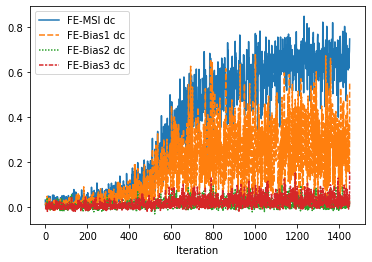

In [91]:
sns.lineplot(data=metrics_df)

In [92]:
loss_df = pd.DataFrame(losses, columns = ['Iteration', 'Loss', 'Task'] )
#loss_df

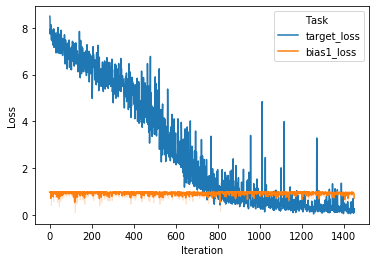

In [93]:

sns.lineplot('Iteration', 'Loss', hue = 'Task', data=loss_df)

In [94]:
loss_df 
#learn.validate()

,Iteration,Loss,Task
0,0,8.487006,target_loss
1,0,0.997727,bias1_loss
2,0,0.974407,bias1_loss
3,1,8.420839,target_loss
4,1,0.996644,bias1_loss
...,...,...,...
4345,1448,0.893383,bias1_loss
4346,1448,0.876065,bias1_loss
4347,1449,0.276152,target_loss
4348,1449,0.792406,bias1_loss


In [ ]:
#learn.show_results()

In [ ]:
#interp = Interpretation.from_learner(learn)

In [ ]:
#interp.plot_top_losses(50, figsize=(30,30))

### Label spot wiht sliding tiles

In [ ]:
if a.pred_patient_img:
    import matplotlib
    #matplotlib.use('Agg') #comment to show images in notebook
    import matplotlib.pyplot as plt



    ds_f = _d_sub.loc[(_d_sub.valid == 1)]


    #ds_f = _d_sub.loc[(_d_sub.spot_ID == '7123')]
    #print(ds_f.valid.mean())


    for spot in ds_f.groupby(['spot_coord','tif_fn'] ):

        spot_coord, tif_fn = spot[0]
        labels = ['Missing', 'MSI', 'MSS']
        img_label = f'{tif_fn}_{spot_coord}_{spot[1].iloc[0].spot_ID}_Label_{labels[int(spot[1].iloc[0].label)]}.png'
        print(img_label)
        spot[1].reset_index(inplace = True)
        sample_spot = learn.dls.test_dl(spot[1] )
        bx=learn.dls.one_batch()[0] #.mean(dim=[0,2,3])
        #print(f'min, max, mean for RGB colors: {bx.min()},{bx.max()},{bx.mean(dim=[0,2,3])}')

        #predict
        imgs, probs, classes, clas_idx = learn.get_preds(dl=sample_spot, with_input=True, with_decoded=True)
        print(f'N of voting tiles: {probs.shape[0]}')

        MSI_score = np.mean(probs.cpu().numpy()[:,1])
        print (f'MSI-score= {MSI_score}')

        ds_spot_4.loc[(ds_spot_4.tif_fn == tif_fn) & (ds_spot_4.spot_coord ==spot_coord) , 'pred_MSI_score_x20'] = MSI_score


        #try:
        #create mask
        size_spot = (300,300) #should match tile size for level 4
        # translate pixel level 0 to mask pixel
        spot_4 = ds_spot_4.loc[(ds_spot_4.spot_coord == spot_coord)&(ds_spot_4.tif_fn == tif_fn)]
        pix_up_left_x = spot_4.iloc[0].tile[0]
        pix_up_left_y = spot_4.iloc[0].tile[1]


        size =  (300,300)
        level = spot[1].iloc[0].tile[3]
        zoom_out = 2**4 #translate absolute pixel from TMA images - level 0 (x40 magnifications) to level 4 (spot enclosed in 300 x 300 pixel image)
        zoom_out_tile = 2**(4-level) #translate absolute pixel from TMA images - level 0 (x40 magnifications) to level 1 (or same level used as TSR dataset , i.e. x 20 magnifications)
        tile_mask_side_length = size[0] / zoom_out_tile

        print(f'Each sliding tile will cover in the mask a square of side {tile_mask_side_length} pixels' )
        print(f'Pixel absolute coordinates in original TMA (upper-left and lower-right corners)')
        print(pix_up_left_x, pix_up_left_y)
        print(spot_4.iloc[0].tile[0] + size_spot[0]* 2**4, spot_4.iloc[0].tile[1] + size_spot[0]* 2**4)
        print(f'Upper left square represents the prediction of tile at level 4')

        #---------------------------------------------
        matrix_prob = pd.DataFrame( columns = np.arange(size_spot[0]), index = np.arange(size_spot[0]))
        matrix_prob = matrix_prob.fillna('np.nan(),')


        for i, row in spot[1].iterrows():

            x,y= (row.tile[0] - pix_up_left_x) / zoom_out, (row.tile[1] - pix_up_left_y) / zoom_out

            zoom_out_tile = 2**(4-level) #translate absolute pixel from TMA images - level 0 (x40 magnifications) to level 1 (or same level used as TSR dataset , i.e. x 20 magnifications)
            tile_mask_side_length = size[0] / zoom_out_tile

            matrix_prob.iloc[round(y) : round(y) + round(tile_mask_side_length), round(x) : round(x) + round(tile_mask_side_length) 
                     ] =  matrix_prob.iloc[round(y) : round(y) + round(tile_mask_side_length), round(x) : round(x) + round(tile_mask_side_length)
                                     ] + str(probs[i][1].cpu().numpy()) + ','




        def f_prob(s):
            result = 0.5 #default (for 0.5) is undecided color in a two-color spectrum
            try:
                p = s.split(',')
                p = list(filter(lambda x: x != '', p))
                if len(p) > 1: 
                    p = p[1:]
                    #p = np.array([float(pro) if (float(pro) < 0.4 or float(pro) > 0.6) else np.nan() for pro in p ])
                    p = np.array([float(pro) for pro in p ])

                    result = np.nanmean(p)

                else:
                    result = float(s)
            except: 
                pass
            return result

        matrix_prob = matrix_prob.applymap(f_prob)
        img_prob = matrix_prob.values






        show_plot = True 
        if show_plot: 
            plt.figure()
            fig, axs = plt.subplots(1, 2, figsize=(30, 15))

            #im1 = axs[1].imshow(get_x(spot_4.iloc[0]), interpolation='nearest')


            im = axs[0].imshow(img_prob, interpolation='nearest', cmap='seismic', vmin=0., vmax=1)
            axs[0].set_title("Mask_MSI_probs")
            cbar = fig.colorbar(im, ax=axs[0], ticks= np.arange(2), fraction = 0.02)
            cbar.ax.set_yticklabels(['MSS','MSI']) 


            show_image(get_x(spot_4.iloc[0]), ax = axs[1], title = spot_4.iloc[0].tile)


            plt.show() 
            plt.close()
            #plt.savefig(img_label)
        #except:
        print('------------------'+ '\n')


#### Study correlations between extracted features and bias 

In [95]:
#preds, targs = learn.get_preds(dl=dls[2], with_input=False, with_loss=False, with_decoded=False, act=None, cbs=[])
preds, targs = learn.get_preds(dl=dls[2],act=noop )


In [96]:
targs

(TensorCategory([0, 0, 0,  ..., 1, 1, 1]),
 TensorCategory([0, 0, 0,  ..., 0, 0, 0]),
 TensorCategory([  52,   52,   52,  ..., 1204,  983, 1229]),
 TensorCategory([ 0,  0,  0,  ..., 28, 28, 20]))

In [97]:
n = len(preds[0])
#idxs = np.random.choice(n//2,n,replace=False)
out = preds[1][:n]
out.shape

torch.Size([3669, 1024])

In [98]:
pca = PCA(n_components=2, whiten=True)
acts_PCA = pca.fit_transform(out)

acts_PCA.shape

(3669, 2)

In [99]:
pca.explained_variance_ratio_.sum()

0.459737121052305

In [100]:
Z_targ = np.array(targs[0].cpu())
Z_bias = np.array(targs[1].cpu())

Z_bias, Z_targ

(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 1, 1, 1]))

In [101]:
Z_bias

array([0, 0, 0, ..., 0, 0, 0])

In [102]:
#remove img where bias = target (criteria)
criteria = Z_bias != Z_targ
#criteria = Z_bias == Z_targ
#criteria = Z_targ == 1
criteria = np.ones_like(Z_bias,dtype=bool)
bias = Z_bias[criteria]
targ = Z_targ[criteria]
pca = acts_PCA[criteria]
print(len(bias))

3669


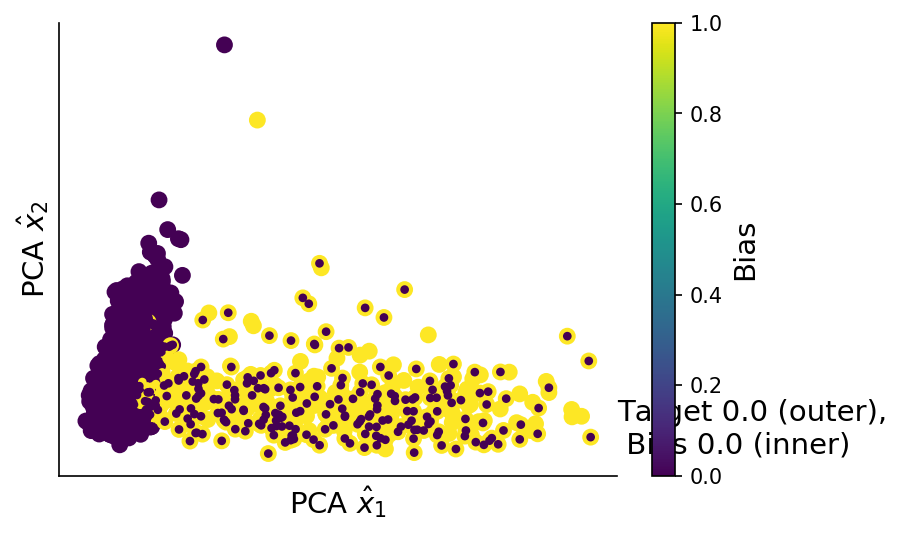

In [103]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)


ax.scatter(pca[:, 0], pca[:, 1], s=50, c=targ)
sc = ax.scatter(pca[:, 0], pca[:, 1], s=10,  c=bias)

ax.text(1, 0.05, f'Target {np.round(targ.mean())} (outer),\n Bias {np.round(bias.mean())} (inner)', transform=plt.gca().transAxes, fontsize=14)

cb = fig.colorbar(sc)
cb.set_label(r'Bias', fontsize=14)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r'PCA $\hat{x}_1$', fontsize=14)
ax.set_ylabel(r'PCA $\hat{x}_2$', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [104]:
cm = feat_target_corr(out.detach()[criteria],targs[0][criteria])
ch = feat_target_corr(out.detach()[criteria],targs[1][criteria])
cp = feat_target_corr(out.detach()[criteria],targs[2][criteria])
ct = feat_target_corr(out.detach()[criteria],targs[3][criteria])
print(f'corr with msi, hospital, patient, TMA: {cm},{ch},{cp},{ct}')

corr with msi, hospital, patient, TMA: 0.6636614288710145,0.2855073398437126,0.01540100774072923,0.03237514220344113


# Results Interpretation 

In [ ]:

#learn.load(model_name)
preds, targs, decoded, losses = learn.get_preds(dl=dls[1], with_input=False, 
                                                with_loss=True, with_decoded=True, 
                                                act=lambda x: torch.softmax(x[0].float(),dim=-1))
#preds, targs, decoded, losses = learn.get_preds(dl=new_dl, with_input=False, with_loss=True, with_decoded=True, act=lambda x: torch.softmax(x.float(),dim=-1), reorder = False)


In [ ]:
#noexport
bt = dls.valid.dataset


In [ ]:
errors_F_neg = np.array(targs[0] - decoded) > 0
F_neg = [i for i, x in enumerate(errors_F_neg) if x]


errors_F_pos = np.array(targs[0] - decoded) < 0
F_pos = [i for i, x in enumerate(errors_F_pos) if x]


def f_neg(x):
    x = F_neg[x]
    print(x,d_sub.loc[d_sub.valid == 1].reset_index().iloc[x])
    print(cls)
    show_at(bt, x, figsize=(5,5))
    lab = ['MSS', 'MSI']
    return f'Loss {losses[x].round()}, Target {lab[targs[0][x]]}, Predicted {lab[decoded[x]]}'

def f_pos(x):
    x = F_pos[x]
    print(x,d_sub.loc[d_sub.valid == 1].reset_index().iloc[x])
    print(cls)
    show_at(bt, x, figsize=(5,5))
    lab = ['MSS', 'MSI']
    return f'Loss {losses[x].round()}, Target {lab[targs[0][x]]}, Predicted {lab[decoded[x]]}'

print(f'ERRORS  F+: {len(F_pos)}, F-: {len(F_neg)}')
print(d_sub.loc[d_sub.valid == 1].reset_index().iloc[F_pos].clas_idx.value_counts() * 100 / d_sub.loc[d_sub.valid == 1].clas_idx.value_counts())
print(d_sub.loc[d_sub.valid == 1].reset_index().iloc[F_neg].clas_idx.value_counts() * 100 / d_sub.loc[d_sub.valid == 1].clas_idx.value_counts())

In [ ]:
#noexport
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



interact(f_neg, x=2);

In [ ]:
#noexport
interact(f_pos, x=2);

In [ ]:
preds_val = preds.float().softmax(dim=-1).cpu()[...,-1]
print(f' N Preds: {preds_val.shape}')


In [ ]:
#noexport
decoded, targs, losses, preds

In [ ]:
#noexport
print(preds.shape, targs[0].shape, losses.shape)

In [ ]:
print('Mean of MSI predicted vs targets')
np.array(decoded).mean(), np.array(targs[0]).mean(),

In [ ]:
preds = preds[targs[0] >= 0]
losses = losses[targs[0] >= 0]
decoded = decoded[targs[0] >= 0]
targs = targs[targs[0] >= 0]


In [ ]:
t = targs[0].cpu().numpy() #MSS is labeled as 0, MSI as 1
p = preds.float().softmax(dim=-1).cpu()[...,-1]
fpr, tpr, thresholds = skm.roc_curve(targs[0].cpu().numpy(),preds.float().softmax(dim=-1).cpu()[...,-1])
fpr, tpr, thresholds = skm.roc_curve(t,p)
#get the best threshold
j = tpr - fpr
ix = np.argmax(j)
best_thresh = thresholds[ix]
auc = skm.auc(fpr, tpr)
print(f'auc = {auc}, best threshold = {best_thresh}')


In [ ]:
#noexport
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MMR estimator')
display.plot() 
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'black', label = 'Best')
plt.show() 

In [ ]:

precision, recall, thresholds = metrics.precision_recall_curve(t,p)


In [ ]:
precision_recall_threshold = np.array(list(zip(precision, recall, thresholds)))
precision_recall_threshold[precision_recall_threshold[:,2] == 0.5]

In [ ]:

precision_recall_threshold[precision_recall_threshold[:,2] == best_thresh]

In [ ]:

fpr, tpr, thresholds = skm.roc_curve(targs[0].cpu().numpy(),preds.float().softmax(dim=-1).cpu()[...,-1])
auc = skm.auc(fpr, tpr)
print(f'auc = {auc}')


In [ ]:
#noexport
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MMR estimator')
display.plot()  
plt.show() 

In [ ]:
#noexport
import seaborn as sns

df = pd.DataFrame(data=np.c_[preds, targs[0], losses, decoded],
                    columns=['preds_0', 'preds_1','target', 'loss', 'decoded'])
df_normal = df.loc[df.target == 0, 'preds_0']
df_MMR = df.loc[df.target == 1, 'preds_1']
df_MMR = 1 - df_MMR

sns.distplot(df_normal, hist=True,  color = "g")
sns.distplot(df_MMR, hist=True, color = "r")

In [ ]:
#noexport
targs[0].cpu().numpy(), preds.float().softmax(dim=-1).cpu()

In [ ]:
#confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
#[[TN,FP],[FN,TP]]
skm.confusion_matrix(targs[0].cpu().numpy(), decoded.cpu())

In [ ]:
best_decoded = preds.float().softmax(dim=-1).cpu()[:,1] > best_thresh


In [ ]:
skm.confusion_matrix(targs[0].cpu().numpy(), best_decoded)

### Agregate prediction by patient

In [ ]:
_d_sub.loc[_d_sub.valid == 1, 'preds'] = np.array(preds_val)

_targs = _d_sub.loc[(_d_sub.valid == 1) & ((_d_sub.bias_label == 11) | (_d_sub.bias_label == 21))  ].groupby('patient_ID').label.mean().values
_preds = _d_sub.loc[(_d_sub.valid == 1) & ((_d_sub.bias_label == 11) | (_d_sub.bias_label == 21)) ].groupby('patient_ID').preds.mean().values
#_targs = _d_sub.loc[(_d_sub.valid == 1) ].groupby('patient_ID').label.mean().values
#_preds = _d_sub.loc[(_d_sub.valid == 1) ].groupby('patient_ID').preds.mean().values

_targs[_targs == 2.0] = 0
_targs[_targs == 1.0] = 1
_preds = _preds[_targs >= 0]

_targs = _targs[_targs >= 0]
#print(_targs,_preds)

t = _targs #MSS is labeled as 0, MSI as 1
p = _preds
fpr, tpr, thresholds = skm.roc_curve(_targs,_preds)
fpr, tpr, thresholds = skm.roc_curve(t,p)
#get the best threshold
j = tpr - fpr
ix = np.argmax(j)
best_thresh = thresholds[ix]
auc = skm.auc(fpr, tpr)
print(f'Agregated auc = {auc}, best threshold = {best_thresh}')


In [ ]:
#noexport
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MMR estimator')
display.plot() 
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'black', label = 'Best')
plt.show() 

In [ ]:
_best_decoded = _preds >= best_thresh
#confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
#[[TN,FP],[FN,TP]]
skm.confusion_matrix(_targs
                     , _best_decoded)

# SHAP

In [ ]:
#noexport
import shap


In [ ]:
b=learn.dls[0].one_batch()

In [ ]:
#noexport
idx = np.random.choice(bs, size = 1)[0]
id1 = idx
id2 = idx + 20 

images = b[0][id1:id2]
targets = b[1][id1:id2]
bias1 = b[2][id1:id2]
idx, targets, bias1,# images

In [ ]:
#noexport
learn.model.force_msi = True
out = learn.model.eval()(images)
out.shape


In [ ]:
#noexport
preds = Tensor(out.cpu().detach().numpy())
preds = preds.float().softmax(dim=-1).cpu()
preds

In [ ]:
#noexport
del out
torch.cuda.empty_cache()
gc.collect()


In [ ]:
images = Tensor(images.cpu()).cuda()
images.shape


In [ ]:
#learn.model.force_msi = True
#noexport
e=shap.DeepExplainer(learn.model,images)


In [ ]:
#noexport

yb= b[1].cpu()
test_labels = np.array(yb[id1:id2])
test_labels

In [ ]:
#noexport
test_images=images
shap_values = e.shap_values(images)
learn.model.force_msi = False

In [ ]:
#noexport
denorm = lambda t:Normalize.from_stats(*tissue_stats).decodes(TensorImage(t))

In [ ]:
#noexport
shap_numpy = [np.swapaxes(np.swapaxes(denorm(s), 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(denorm(images).cpu().numpy(), 1, -1), 1, 2)
test_numpy.shape

In [ ]:
preds, targets, 

In [ ]:
#noexport
shap.image_plot(shap_numpy, test_numpy, labels= preds)